# Miniproject 1: Image Classification

## Introduction

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://deeplearning.net/tutorial/logreg.html). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that was [recently extended](https://arxiv.org/abs/1702.05373). We break with this tradition (just a little bit) and tackle first the related problem of classifying cropped, downsampled and grayscaled images of house numbers in the [The Street View House Numbers (SVHN) Dataset](http://ufldl.stanford.edu/housenumbers/).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook.

### Your names

Before you start, please enter your full name(s) in the field below; they are used to load the data. The variable student2 may remain empty, if you work alone.

In [1]:
SCIPER1 = 268578
SCIPER2 = 0
#i worked together with Nikita Lazarev, but we didn't share much of a code

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io
import pickle

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import SGD, Adam
from keras.regularizers import l1, l2
from keras.models import load_model

# you may experiment with different subsets, 
# but make sure in the submission 
# it is generated with the correct random seed for all exercises.
np.random.seed(SCIPER1 + SCIPER2)
subset_of_classes = np.random.choice(range(10), 5, replace = False)

Using TensorFlow backend.


### Plotting

In [3]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 16, ydim = 16,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig

def plot_history_two(history1, history2, title, labels = ['sgd', 'adam']):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history1.history['loss'], label = "training_"+labels[0])
    ax1.plot(history1.history['val_loss'], label = "validation_"+labels[0])
    ax2.plot(history1.history['acc'], label = "training_"+labels[0])
    ax2.plot(history1.history['val_acc'], label = "validation_"+labels[0])
    ax1.plot(history2.history['loss'], label = "training_"+labels[1])
    ax1.plot(history2.history['val_loss'], label = "validation_"+labels[1])
    ax2.plot(history2.history['acc'], label = "training_"+labels[1])
    ax2.plot(history2.history['val_acc'], label = "validation_"+labels[1])
    finalize_standardplot(fig, ax1, ax2)
    return fig

def plot_layers(x, y_loss, y_acc):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('hidden_layers')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('# hidden layers')
    ax1.plot(x, y_loss)
    ax2.set_ylabel('acc')
    ax2.set_xlabel('# hidden layers')
    ax2.plot(x, y_acc)
    finalize_standardplot(fig, ax1, ax2)

### Loading and preprocessing the data

The data consists of RGB color images with 32x32 pixels, loaded into an array of dimension 32x32x3x(number of images). We convert them to grayscale (using [this method](https://en.wikipedia.org/wiki/SRGB#The_reverse_transformation)) and we downsample them to images of 16x16 pixels by averaging over patches of 2x2 pixels.

With these preprocessing steps we obviously remove some information that could be helpful in classifying the images. But, since the processed data is much lower dimensional, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish. After having gained some experience, one may want to go back to work on the 32x32 RGB images.


In [4]:
# convert RGB images x to grayscale using the formula for Y_linear in https://en.wikipedia.org/wiki/Grayscale#Colorimetric_(perceptual_luminance-preserving)_conversion_to_grayscale
def grayscale(x):
    x = x.astype('float32')/255
    x = np.piecewise(x, [x <= 0.04045, x > 0.04045], 
                        [lambda x: x/12.92, lambda x: ((x + .055)/1.055)**2.4])
    return .2126 * x[:,:,0,:] + .7152 * x[:,:,1,:]  + .07152 * x[:,:,2,:]

def downsample(x):
    return sum([x[i::2,j::2,:] for i in range(2) for j in range(2)])/4

def preprocess(data):
    gray = grayscale(data['X'])
    downsampled = downsample(gray)
    return (downsampled.reshape(16*16, gray.shape[2]).transpose(),
            data['y'].flatten() - 1)


data_train = scipy.io.loadmat('housenumbers/train_32x32.mat')
data_test = scipy.io.loadmat('housenumbers/test_32x32.mat')

x_train_all, y_train_all = preprocess(data_train)
x_test_all, y_test_all = preprocess(data_test)

### Selecting a subset of classes

We furter reduce the size of the dataset (and thus reduce computation time) by selecting only the 5 (out of 10 digits) in subset_of_classes.

In [5]:
def extract_classes(x, y, classes):
    indices = []
    labels = []
    count = 0
    for c in classes:
        tmp = np.where(y == c)[0]
        indices.extend(tmp)
        labels.extend(np.ones(len(tmp), dtype='uint8') * count)
        count += 1
    return x[indices], labels

x_train, y_train = extract_classes(x_train_all, y_train_all, subset_of_classes)
x_test, y_test = extract_classes(x_test_all, y_test_all, subset_of_classes)

Let us plot some examples now. The green digit at the bottom left of each image indicates the corresponding label in y_test.
For further usage of the function plot_some_samples, please have a look at its definition in the plotting section.

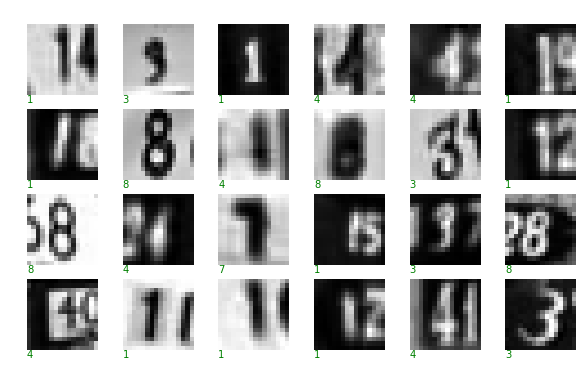

In [6]:
plot_some_samples(x_test, y_test, label_mapping = subset_of_classes);

To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing).

In [7]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

y_train.shape
indices = np.random.permutation(x_train.shape[0])
x_train = x_train[indices]
y_train = y_train[indices]

In [8]:
w_init = keras.initializers.glorot_normal(seed=None) #xavier
b_init = keras.initializers.Zeros()
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0),
]

## Exercise 1: No hidden layer

### Description

Define and fit a model without a hidden layer. 

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)`


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

#### Util functions

In [10]:
def one_layer():

    model = Sequential()
    model.add(Dense(y_train.shape[1], input_dim=x_train.shape[1], activation='softmax', name='Y'))

    model.compile(loss='categorical_crossentropy', 
                optimizer=SGD(),
                metrics=['accuracy'])

    model.summary()
    return model

#### Train model

In [21]:
model = one_layer()
history = model.fit(x_train, y_train,  validation_data=(x_test, y_test), batch_size=128, epochs=40, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Y (Dense)                    (None, 5)                 1285      
Total params: 1,285
Trainable params: 1,285
Non-trainable params: 0
_________________________________________________________________
Train on 40456 samples, validate on 14183 samples
Epoch 1/40
40456/40456 [==============================] - 1s 23us/step - loss: 1.5633 - acc: 0.3403 - val_loss: 1.5523 - val_acc: 0.3515
Epoch 2/40
40456/40456 [==============================] - 1s 21us/step - loss: 1.5522 - acc: 0.3406 - val_loss: 1.5398 - val_acc: 0.3592
Epoch 3/40
40456/40456 [==============================] - 1s 18us/step - loss: 1.5447 - acc: 0.3416 - val_loss: 1.5343 - val_acc: 0.3601
Epoch 4/40
40456/40456 [==============================] - 1s 18us/step - loss: 1.5397 - acc: 0.3425 - val_loss: 1.5301 - val_acc: 0.3609
Epoch 5/40
40456/40456 [==============================] - 1s 17us/step

#### Use model

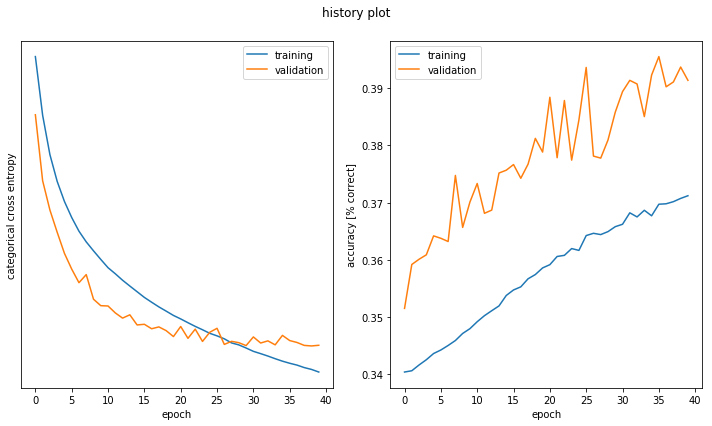

In [22]:
res = plot_history(history, "history plot")

We observe that around epoch 40 validation loss starts to increase, this means that from this moment on, our model is starting to overfit.

#### Test images that are misclassified

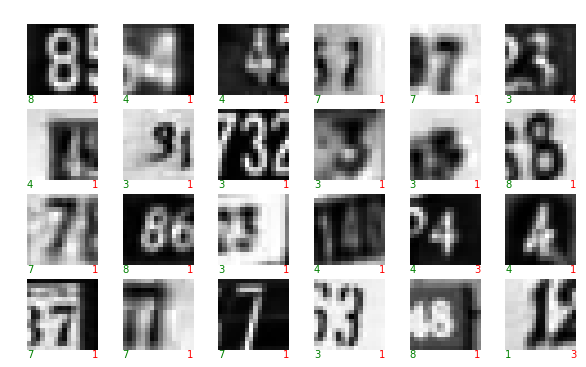

In [24]:
yhat_test = model.predict(x_test)
error_indices = np.arange(x_test.shape[0])[np.argmax(yhat_test, axis=1)!=np.argmax(y_test, axis=1)]
res = plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)

## Exercise 2: One hidden layer, different optizimizers
### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 64 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to inspect your model.
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent and answer the question below.
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam).
4. Plot the learning curves of SGD with a reasonable learning rate together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot.

### Solution

#### Util functions

In [37]:
def one_hidden_layer(opt, hidden_units=64, epochs=50, plot=True, call=[]):

    model = Sequential()
    model.add(Dense(hidden_units, input_dim=x_train.shape[1], activation='relu', name='H1'))
    model.add(Dense(y_train.shape[1], activation='softmax', name='Y'))

    model.compile(loss='categorical_crossentropy', 
                optimizer=opt,
                metrics=['accuracy'])
    
    history = model.fit(x_train, y_train,  validation_data=(x_test, y_test), batch_size=128, epochs=epochs, verbose=0, callbacks=call)
    if plot: plot_history(history, "history plot")
    model.summary()
    return model, history

#### Train models

##### Different learning rates with SGD

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                16448     
_________________________________________________________________
Y (Dense)                    (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________


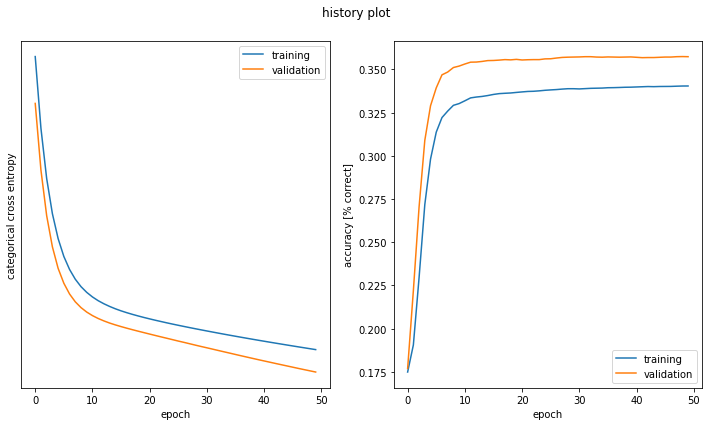

In [26]:
#learning rate =0.001
model, _ = one_hidden_layer(SGD(lr = 0.0001))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                16448     
_________________________________________________________________
Y (Dense)                    (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________


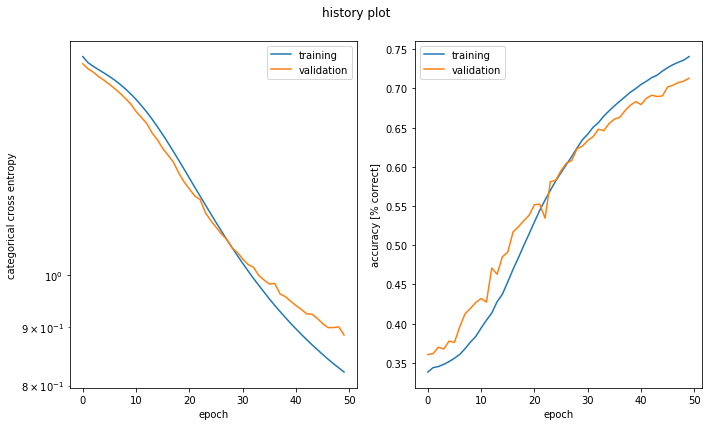

In [27]:
#learning rate =1
model, _ = one_hidden_layer(SGD(lr = 0.01))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                16448     
_________________________________________________________________
Y (Dense)                    (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________


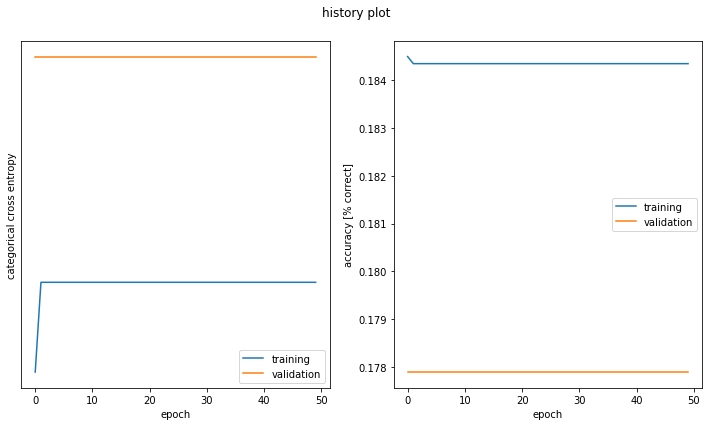

In [28]:
#learning rate =100
model, _ = one_hidden_layer(SGD(lr = 10))

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence (double click this markdown cell to edit).

**Answer**:

A) If the learning rate is too small, optmization algorithm converges very slowly, and it can take a very long time to train the model (case when the learning rate is 0.0001).

B) If the learning rate is too big, optimization algorithm is going to make very big steps and it will end up converging (not finding minimum at all) (case when the learning rate is 10).

##### Training with Adam

In [29]:
model_sgd, history_sgd = one_hidden_layer(SGD(lr = 0.01), plot =False) 
model_adam, history_adam = one_hidden_layer(Adam(lr = 0.01), plot = False) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                16448     
_________________________________________________________________
Y (Dense)                    (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                16448     
_________________________________________________________________
Y (Dense)                    (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________


#### Use models

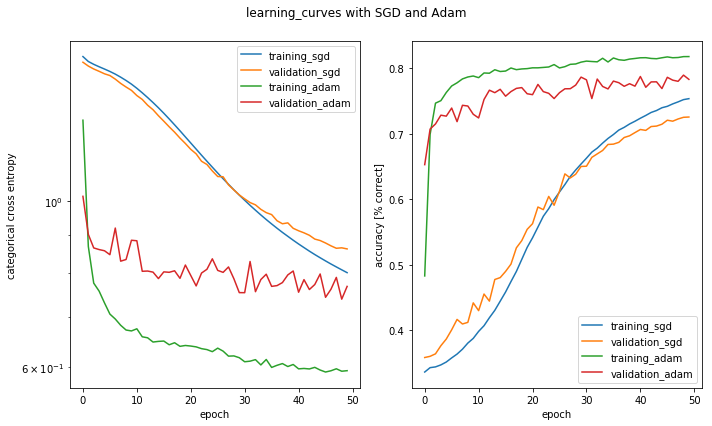

In [30]:
res = plot_history_two(history_sgd, history_adam, "learning_curves with SGD and Adam")

We observe that for the same learning rate, Adam optimizer converges quicker.

## Exercise 3: Overfitting and early stopping with Adam

### Description

Run the above simulation with Adam for sufficiently many epochs (be patient!) until you see clear overfitting.

1. Plot the learning curves of a fit with Adam and sufficiently many epochs and answer the questions below.

A simple, but effective mean to avoid overfitting is early stopping, i.e. a fit is not run until convergence but stopped as soon as the validation error starts to increase. We will use early stopping in all subsequent exercises.

### Solution

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                16448     
_________________________________________________________________
Y (Dense)                    (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________


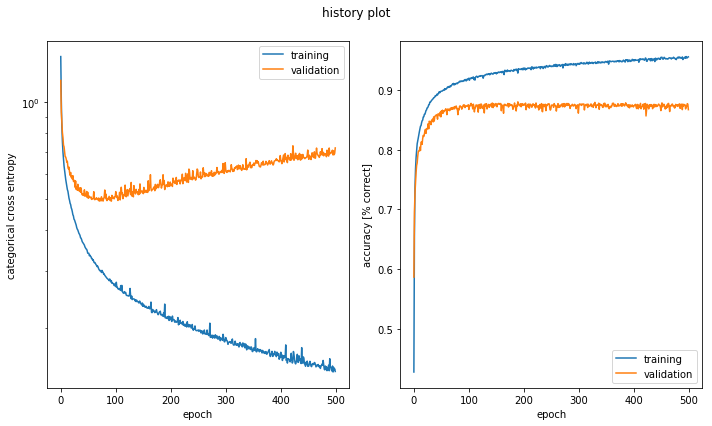

In [48]:
model_adam, history_adam = one_hidden_layer(Adam(lr = 0.001), epochs=500) 

**Question 1**: At which epoch (approximately) does the model start to overfit? Please answer with one full sentence.

**Answer**: Model starts to overfit around 50 epochs (validation loss starts to grow from that point on). 

**Question 2**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: Considering loss curves, we observe that after certain amount of training epochs, training loss keeps decreasing, while validation loss starts to increase. This is the sign that we started to fit to noise of training data and we should avoid this in order to make our model work for new data as well. Considering accuracy, we notice that after certaing number of epochs train accuracy is still increasing, while validation accuracy stands pretty still (decreases very slowly compared to loss). This is happening because accuracy can remain flat while the loss gets worse as long as the scores don't cross the threshold where the predicted class changes.

## Exercise 4: Model performance as a function of number of hidden neurons

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models with different hidden layer size (between 10 and 1000 hidden neurons) for a fixed number of epochs well beyond the point of overfitting.
2. Collect some statistics by fitting the same models as in 1. for multiple initial conditions. Hints: 1. If you don't reset the random seed, you get different initial conditions each time you create a new model. 2. Let your computer work while you are asleep.
3. Plot summary statistics of the final validation loss and accuracy versus the number of hidden neurons. Hint: [boxplots](https://matplotlib.org/examples/pylab_examples/boxplot_demo.html) (also [here](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.boxplot.html?highlight=boxplot#matplotlib.axes.Axes.boxplot)) are useful. You may also want to use the matplotlib method set_xticklabels.
4. Plot summary statistics of the loss and accuracy for early stopping versus the number of hidden neurons.

### Solution

#### Util functions

In [12]:
#function to find best validation loss and best validation accuracy
def find_best_loss_acc(history):
    return min(history.history['val_loss']), max(history.history['val_acc'])  

def find_final_loss_acc(history):
    return np.mean(history.history['val_loss'][-10:]), np.mean(history.history['val_acc'][-10])

#### Train models

In [ ]:
hidden = [10, 50, 100, 200, 500, 1000]
N=5

In [57]:
#without early stopping
models=[[{'loss':[], 'acc':[]}] for x in range(6)]
for i in range(N):
    for k, N_h in enumerate(hidden):
        print("{} -th iteration, N_h = {} model".format(i, k))
        model, history = one_hidden_layer(Adam(lr = 0.01), hidden_units = N_h, epochs=400, plot=False) 
        loss, acc= find_final_loss_acc(history)
        models[k][0]["loss"].append(loss)
        models[k][0]["acc"].append(acc)
pickle.dump(models, open("task4_model_overfitting.p", "wb"))

0 -th iteration, N_h = 0 model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 10)                2570      
_________________________________________________________________
Y (Dense)                    (None, 5)                 55        
Total params: 2,625
Trainable params: 2,625
Non-trainable params: 0
_________________________________________________________________
0 -th iteration, N_h = 1 model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 50)                12850     
_________________________________________________________________
Y (Dense)                    (None, 5)                 255       
Total params: 13,105
Trainable params: 13,105
Non-trainable params: 0
_________________________________________________________________
0 -th it

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 50)                12850     
_________________________________________________________________
Y (Dense)                    (None, 5)                 255       
Total params: 13,105
Trainable params: 13,105
Non-trainable params: 0
_________________________________________________________________
2 -th iteration, N_h = 2 model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 100)               25700     
_________________________________________________________________
Y (Dense)                    (None, 5)                 505       
Total params: 26,205
Trainable params: 26,205
Non-trainable params: 0
_________________________________________________________________
2 -th iteration, N_h = 3 model
______

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 200)               51400     
_________________________________________________________________
Y (Dense)                    (None, 5)                 1005      
Total params: 52,405
Trainable params: 52,405
Non-trainable params: 0
_________________________________________________________________
4 -th iteration, N_h = 4 model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 500)               128500    
_________________________________________________________________
Y (Dense)                    (None, 5)                 2505      
Total params: 131,005
Trainable params: 131,005
Non-trainable params: 0
_________________________________________________________________
4 -th iteration, N_h = 5 model
____

In [81]:
#with early stoppping
models_early=[[{'loss':[], 'acc':[]}] for x in range(6)]
for i in range(N):
    for k, N_h in enumerate(hidden):
        print("{} -th iteration, N_h = {} model".format(i, k))
        model, history = one_hidden_layer(Adam(lr = 0.01), hidden_units = N_h, epochs=200, plot=False) 
        loss, acc= find_best_loss_acc(history)
        models_early[k][0]["loss"].append(loss)
        models_early[k][0]["acc"].append(acc)
pickle.dump(models_early, open("task4_model_earlystopping.p", "wb"))

0 -th iteration, N_h = 0 model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 10)                2570      
_________________________________________________________________
Y (Dense)                    (None, 5)                 55        
Total params: 2,625
Trainable params: 2,625
Non-trainable params: 0
_________________________________________________________________
0 -th iteration, N_h = 1 model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 50)                12850     
_________________________________________________________________
Y (Dense)                    (None, 5)                 255       
Total params: 13,105
Trainable params: 13,105
Non-trainable params: 0
_________________________________________________________________
0 -th it

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 50)                12850     
_________________________________________________________________
Y (Dense)                    (None, 5)                 255       
Total params: 13,105
Trainable params: 13,105
Non-trainable params: 0
_________________________________________________________________
2 -th iteration, N_h = 2 model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 100)               25700     
_________________________________________________________________
Y (Dense)                    (None, 5)                 505       
Total params: 26,205
Trainable params: 26,205
Non-trainable params: 0
_________________________________________________________________
2 -th iteration, N_h = 3 model
______

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 200)               51400     
_________________________________________________________________
Y (Dense)                    (None, 5)                 1005      
Total params: 52,405
Trainable params: 52,405
Non-trainable params: 0
_________________________________________________________________
4 -th iteration, N_h = 4 model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 500)               128500    
_________________________________________________________________
Y (Dense)                    (None, 5)                 2505      
Total params: 131,005
Trainable params: 131,005
Non-trainable params: 0
_________________________________________________________________
4 -th iteration, N_h = 5 model
____

KeyboardInterrupt: 

#### Use models

Text(0,0.5,'loss')

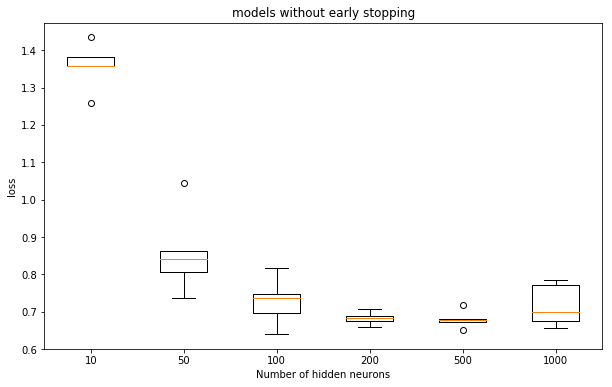

In [58]:
plt.boxplot((models[0][0]['loss'], models[1][0]['loss'], models[2][0]['loss'], models[3][0]['loss'], models[4][0]['loss'], models[5][0]['loss']))
plt.xticks([1, 2, 3, 4, 5, 6], hidden) 
plt.title("models without early stopping")
plt.xlabel("Number of hidden neurons")
plt.ylabel("loss")

In [102]:
#plt.boxplot([models[0][0]['acc'], models[1][0]['acc'], models[2][0]['acc'], models[3][0]['acc'], models[4][0]['acc'], models[5][0]['acc']])
#plt.xticks([1, 2, 3, 4, 5, 6], hidden) 
#plt.title("models without early stopping")
#plt.xlabel("Number of hidden neurons")
#plt.ylabel("acc")

Text(0,0.5,'loss')

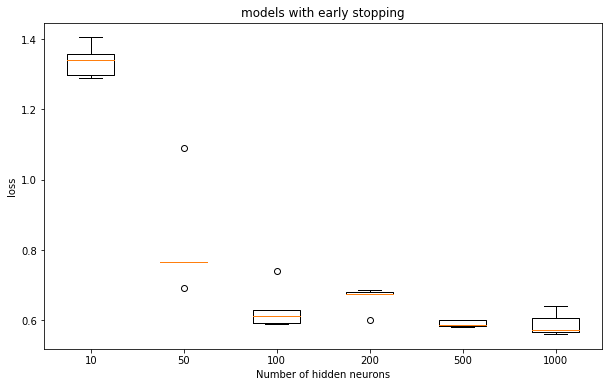

In [103]:
plt.boxplot((models_early[0][0]['loss'], models_early[1][0]['loss'], models_early[2][0]['loss'], models_early[3][0]['loss'], models_early[4][0]['loss'], models_early[5][0]['loss']))
plt.xticks([1, 2, 3, 4, 5, 6], hidden)
plt.title("models with early stopping")
plt.xlabel("Number of hidden neurons")
plt.ylabel("loss")

Text(0,0.5,'acc')

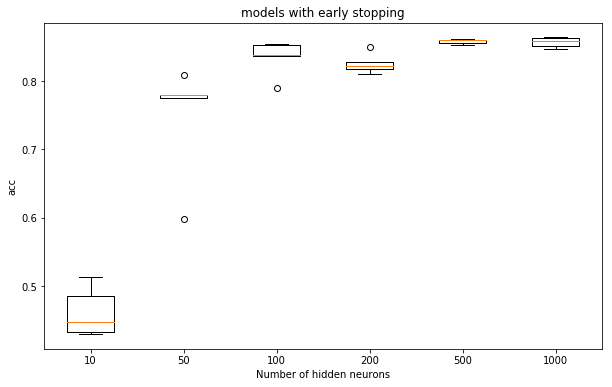

In [104]:
plt.boxplot([models_early[0][0]['acc'], models_early[1][0]['acc'], models_early[2][0]['acc'], models_early[3][0]['acc'], models_early[4][0]['acc'], models_early[5][0]['acc']])
plt.xticks([1, 2, 3, 4, 5, 6], hidden) 
plt.title("models with early stopping")
plt.xlabel("Number of hidden neurons")
plt.ylabel("acc")

We observe that withouth early stopping loss goes down for models with smaller number of neurons, however once the model reaches certain complexity (1000 neruons) loss start to increase. On the other hand, with early stopping, model with 1000 neurons has the best loss because we use early stoping as reguralization. In terms of accuracy, there is not much difference, because overfitting affects accuracy measure less than loss meassure.

## Exercise 5: Comparison to deep models

### Description

Instead of choosing one hidden layer (with many neurons) you experiment here with multiple hidden layers (each with not so many neurons).

1. Fit models with 2, 3 and 4 hidden layers with approximately the same number of parameters as a network with one hidden layer of 100 neurons. Hint: Calculate the number of parameters in a network with input dimensionality N_in, K hidden layers with N_h units, one output layer with N_out dimensions and solve for N_h. Confirm you result with the keras method model.summary().
2. Run each model multiple times with different initial conditions and plot summary statistics of the best validation loss and accuracy versus the number of hidden layers.

### Solution

#### Util functions

In [67]:
def multiple_hidden_layers(opt, w_reg=None, b_reg=None, dropout =None, batch_norm = False, N_h=64, K =1, epochs=50, plot=True, verb = 0, call=[]):

    model = Sequential()
    
    #first_hidden_layer
    model.add(Dense(N_h, input_dim=x_train.shape[1], \
                    kernel_initializer=w_init, bias_initializer=b_init, \
                    kernel_regularizer=w_reg, bias_regularizer = b_reg, activation='relu'))
    if batch_norm: model.add(keras.layers.BatchNormalization())
    if dropout: model.add(keras.layers.Dropout(dropout))
    
    #hidden layers
    for l in range(K-1):
        model.add(Dense(N_h , kernel_initializer=w_init, bias_initializer=b_init, kernel_regularizer=w_reg, \
                        bias_regularizer = b_reg, activation='relu'))
        if batch_norm: model.add(keras.layers.BatchNormalization())
        if dropout: model.add(keras.layers.Dropout(dropout))
        
            
    #output layer
    model.add(Dense(y_train.shape[1], kernel_initializer=w_init, bias_initializer=b_init, kernel_regularizer=w_reg, \
                    bias_regularizer = b_reg, activation='softmax'))

    model.compile(loss='categorical_crossentropy', 
                optimizer=opt,
                metrics=['accuracy'])
    
    history = model.fit(x_train, y_train,  validation_data=(x_test, y_test), batch_size=128, epochs=epochs, verbose=verb)
    if plot: plot_history(history, "history plot")
    model.summary()
    return model, history

#### Calculating number of hidden units

In [68]:
#K=1, #of hidden units = 100
256*100 + 100 + 100*5+5

26205

In [69]:
#K=2
#256*N_h + N_h + N_h*N_h + N_h + N_h*5+5 = 26205
#<=> 263*N_h + N_h*N_h - 26200 = 0
print("K==2: {}".format(np.roots([1, 263, -26200]))) 

#K=3
#256*N_h + N_h + 2*N_h*N_h + 2*N_h + N_h*5+5 = 26205
#<=> 264*N_h + 2*N_h*N_h - 26200 = 0
print("K==3: {}".format(np.roots([2, 264, -26200]))) 

#K=2
#256*N_h + N_h + 3*N_h*N_h + 3*N_h + N_h*5+5 = 26205
#<=> 265*N_h + 3*N_h*N_h - 26200 = 0
print("K==4: {}".format(np.roots([3, 265, -26200]))) 

K==2: [-340.04795612   77.04795612]
K==3: [-198.12115652   66.12115652]
K==4: [-147.53023751   59.19690418]


In [70]:
#check - model with one hidden layer and 100 hidden units
model, _ = one_hidden_layer(SGD(lr = 0.01),  hidden_units=100, epochs=1, plot=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 100)               25700     
_________________________________________________________________
Y (Dense)                    (None, 5)                 505       
Total params: 26,205
Trainable params: 26,205
Non-trainable params: 0
_________________________________________________________________


In [71]:
#check - model with multiple layers

model, _ = multiple_hidden_layers(Adam(lr = 0.01), N_h=77, K=2, epochs=1, plot=False)
model, _ = multiple_hidden_layers(Adam(lr = 0.01), N_h=66, K=3, epochs=1, plot=False)
model, _ = multiple_hidden_layers(Adam(lr = 0.01), N_h=59, K=4, epochs=1, plot=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 77)                19789     
_________________________________________________________________
dense_2 (Dense)              (None, 77)                6006      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 390       
Total params: 26,185
Trainable params: 26,185
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 66)                16962     
_________________________________________________________________
dense_5 (Dense)              (None, 66)                4422      
_________________________________________________________________
dense_

From the above we observe that the number of paramateres in networks with multiple layers in very close to number of parameters of network with one hidden layer with 100 hidden units, what is exactly what we calculated and wanted.

#### Train models multiple times with different initial conditions

0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 77)                19789     
_________________________________________________________________
dense_14 (Dense)             (None, 77)                6006      
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 390       
Total params: 26,185
Trainable params: 26,185
Non-trainable params: 0
_________________________________________________________________
1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 77)                19789     
_________________________________________________________________
dense_17 (Dense)             (None, 77)                6006      
_________________________________________________________________
de

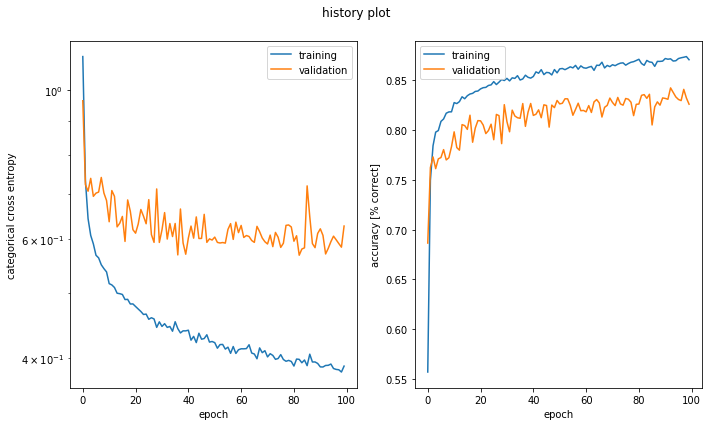

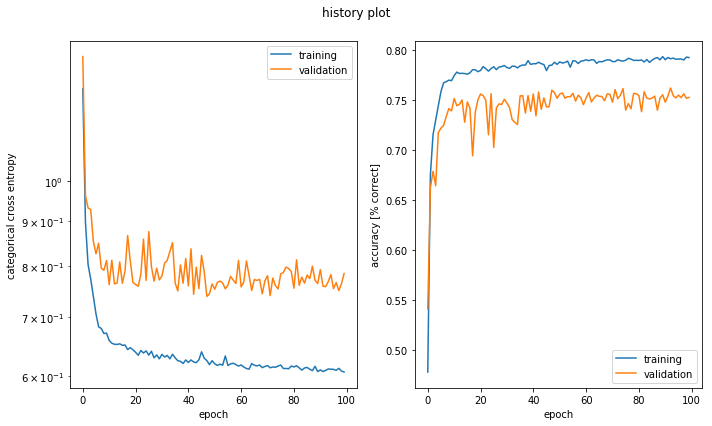

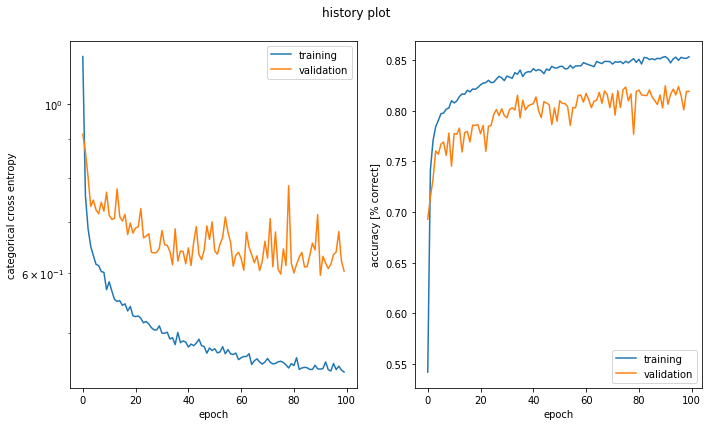

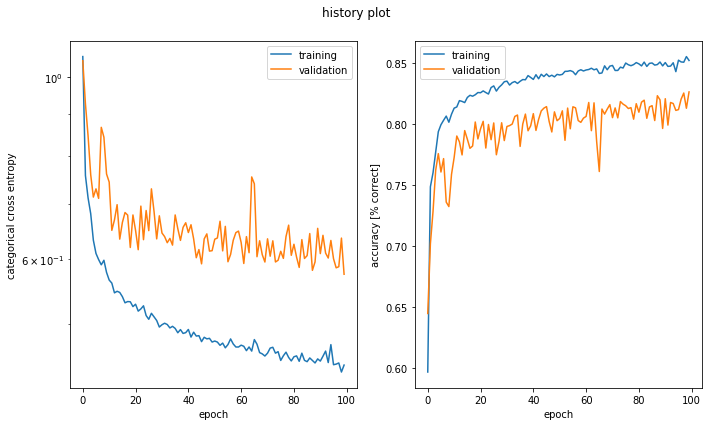

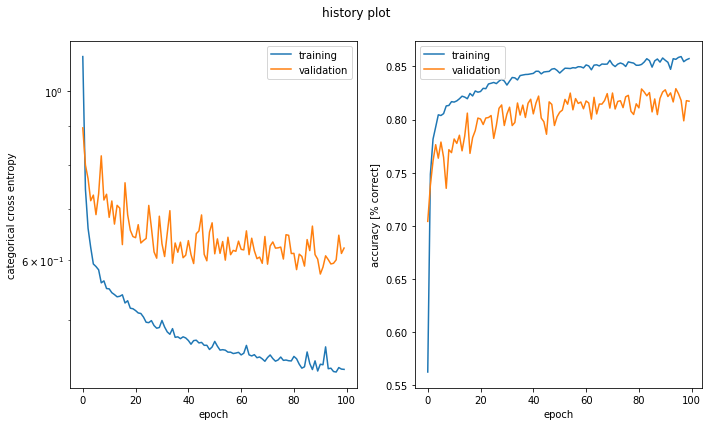

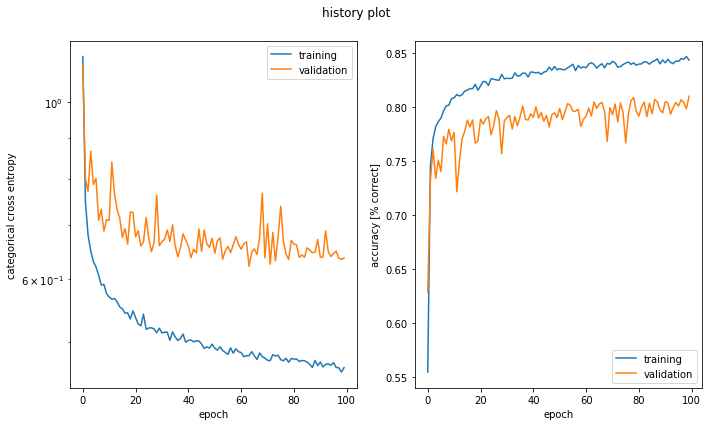

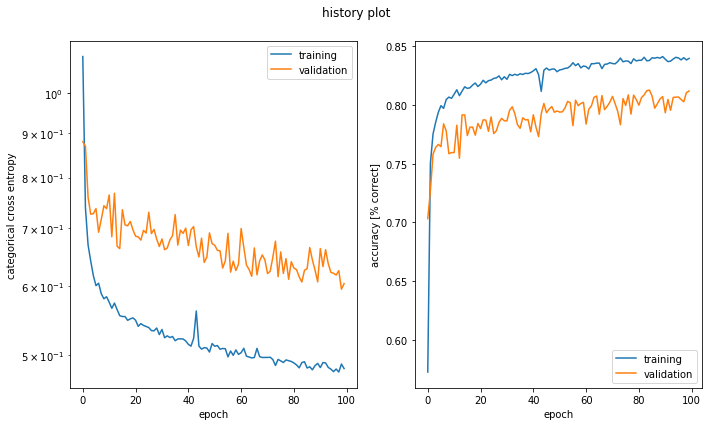

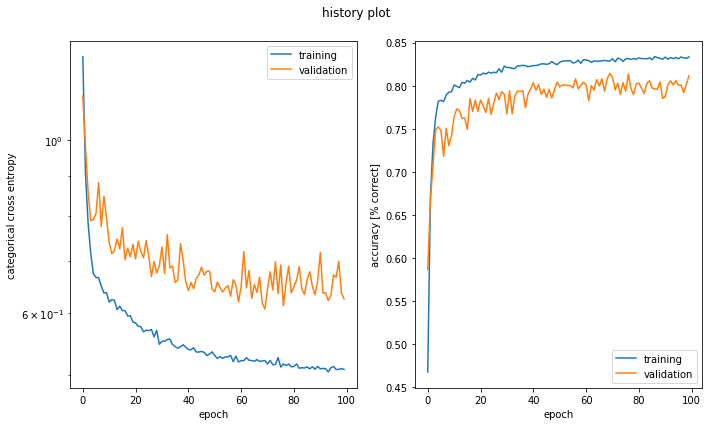

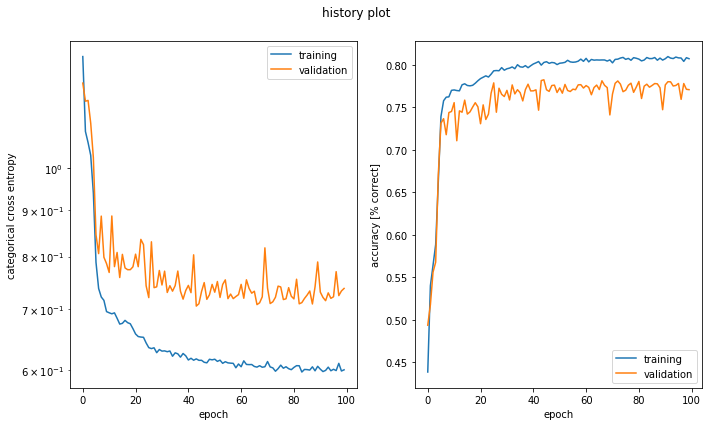

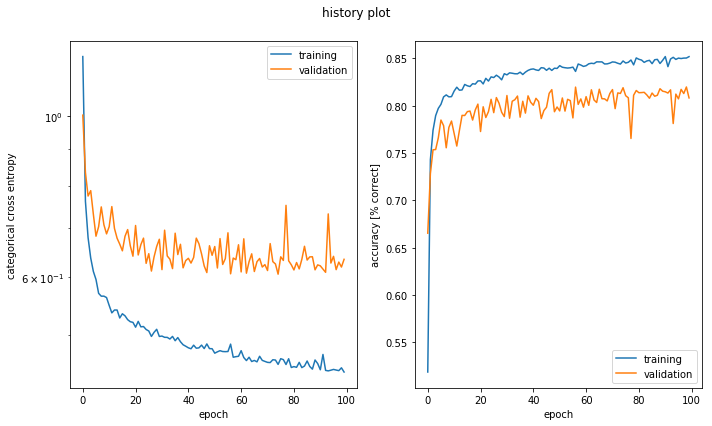

In [72]:
#K=2
N=10
model_2={'loss':[], 'acc':[]}
for i in range(N):
    print(i)
    model, history = multiple_hidden_layers(Adam(lr = 0.01), N_h=77, epochs = 100, K=2, plot=True) 
    loss, acc= find_best_loss_acc(history)
    model_2["loss"].append(loss)
    model_2["acc"].append(acc)
pickle.dump(model_2, open("task5_model_2.p", "wb"))

0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 77)                19789     
_________________________________________________________________
dense_44 (Dense)             (None, 77)                6006      
_________________________________________________________________
dense_45 (Dense)             (None, 77)                6006      
_________________________________________________________________
dense_46 (Dense)             (None, 5)                 390       
Total params: 32,191
Trainable params: 32,191
Non-trainable params: 0
_________________________________________________________________
1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 77)                19789     
_________________________________________________________________
de

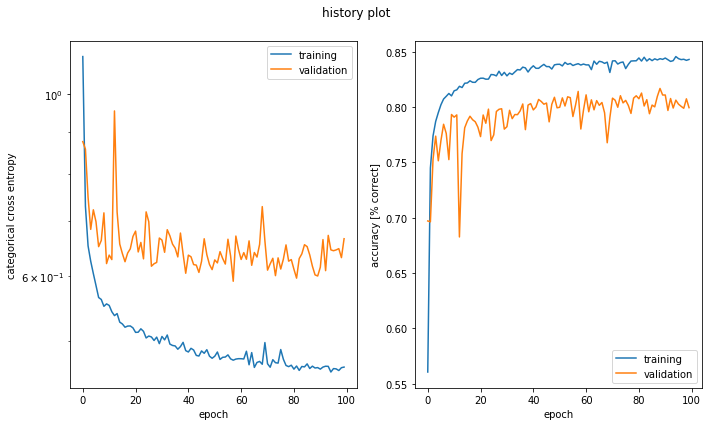

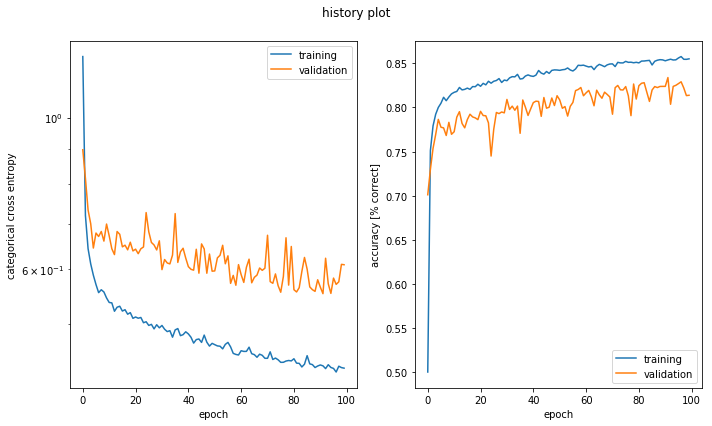

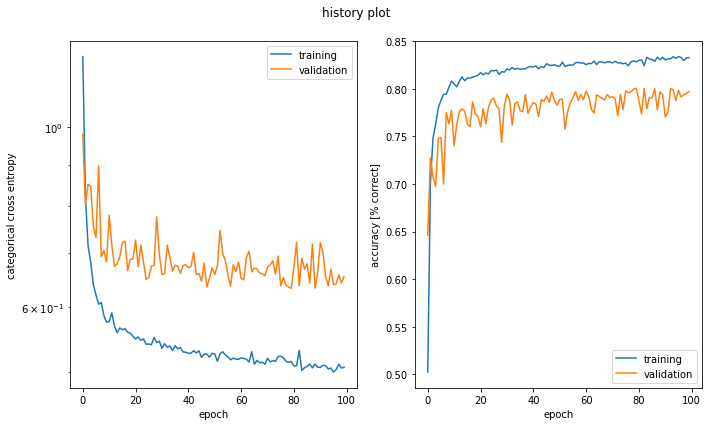

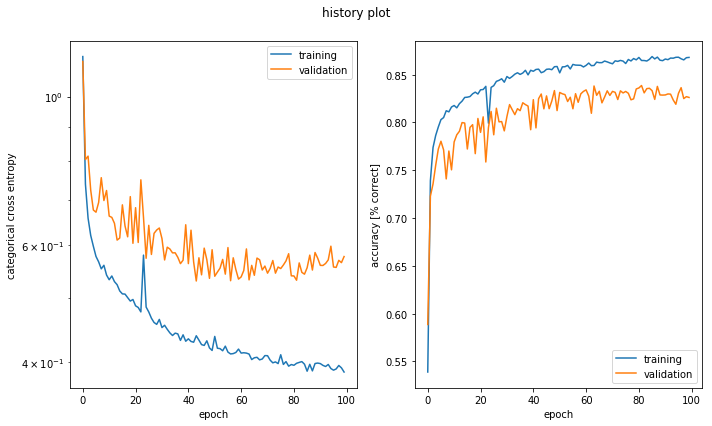

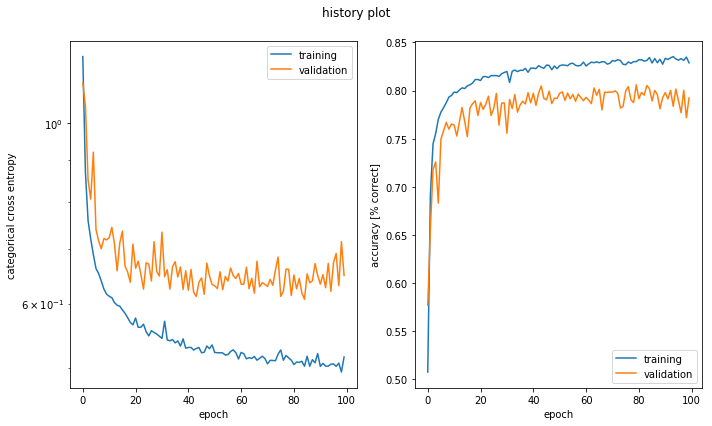

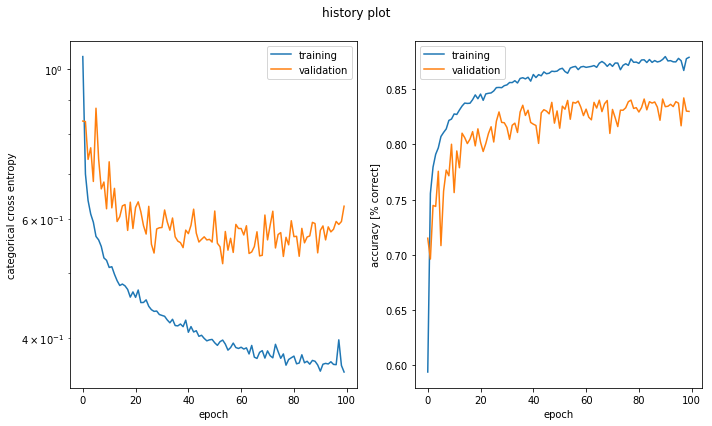

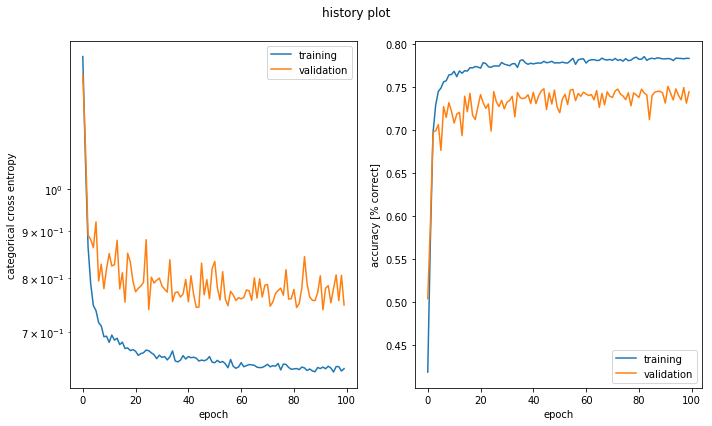

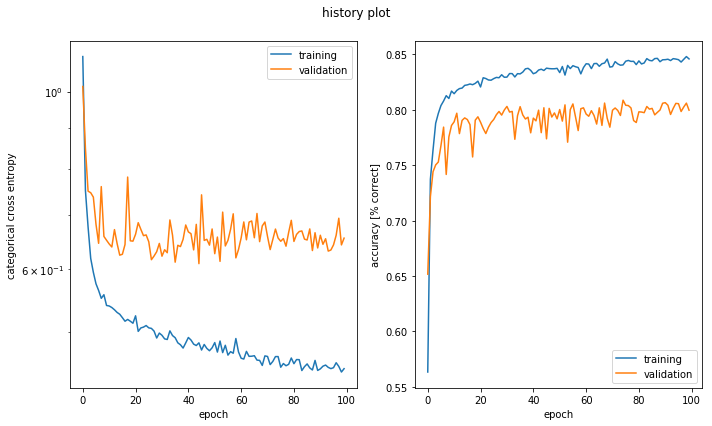

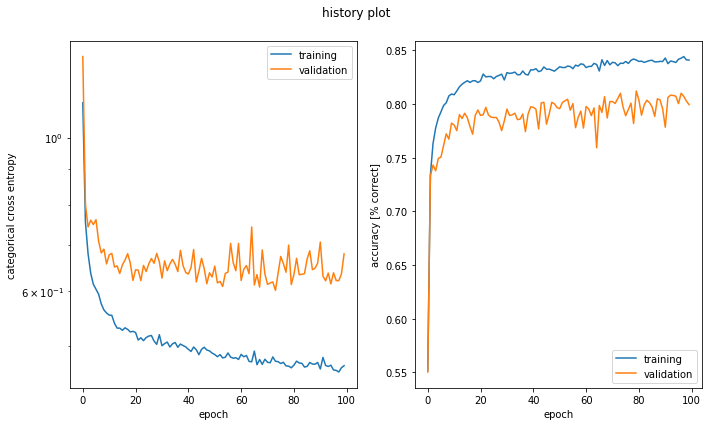

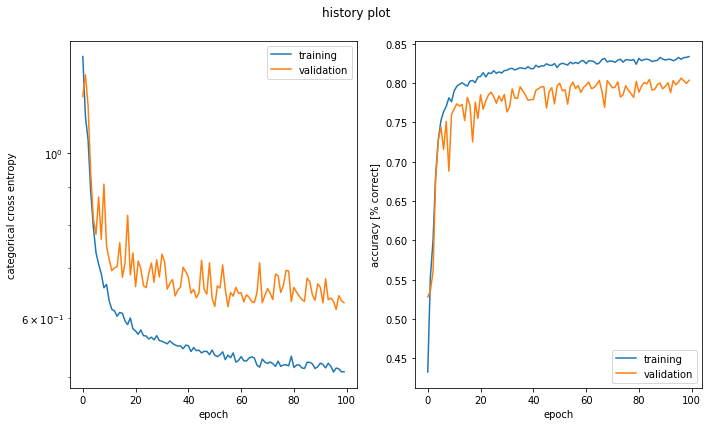

In [73]:
#K=3
model_3={'loss':[], 'acc':[]}
for i in range(N):
    print(i)
    model, history = multiple_hidden_layers(Adam(lr = 0.01), N_h=77, K=3, epochs = 100, plot=True)
    loss, acc= find_best_loss_acc(history)
    model_3["loss"].append(loss)
    model_3["acc"].append(acc)
pickle.dump(model_3, open("task5_model_3.p", "wb"))

0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_83 (Dense)             (None, 77)                19789     
_________________________________________________________________
dense_84 (Dense)             (None, 77)                6006      
_________________________________________________________________
dense_85 (Dense)             (None, 77)                6006      
_________________________________________________________________
dense_86 (Dense)             (None, 77)                6006      
_________________________________________________________________
dense_87 (Dense)             (None, 5)                 390       
Total params: 38,197
Trainable params: 38,197
Non-trainable params: 0
_________________________________________________________________
1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
de

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_128 (Dense)            (None, 77)                19789     
_________________________________________________________________
dense_129 (Dense)            (None, 77)                6006      
_________________________________________________________________
dense_130 (Dense)            (None, 77)                6006      
_________________________________________________________________
dense_131 (Dense)            (None, 77)                6006      
_________________________________________________________________
dense_132 (Dense)            (None, 5)                 390       
Total params: 38,197
Trainable params: 38,197
Non-trainable params: 0
_________________________________________________________________


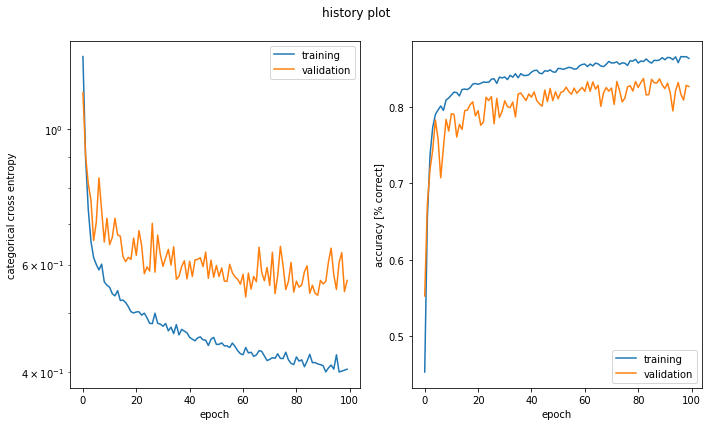

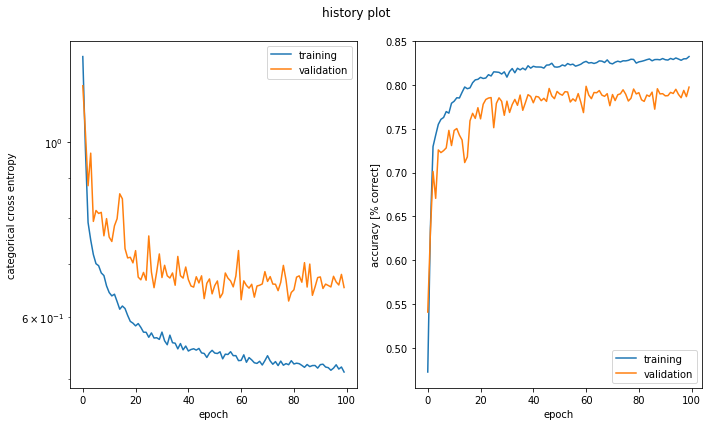

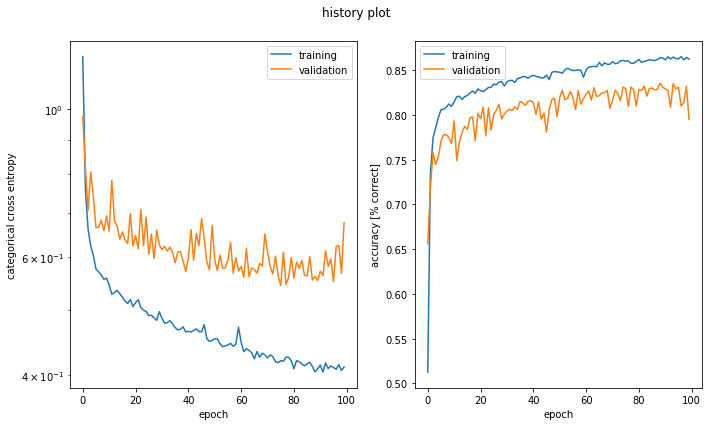

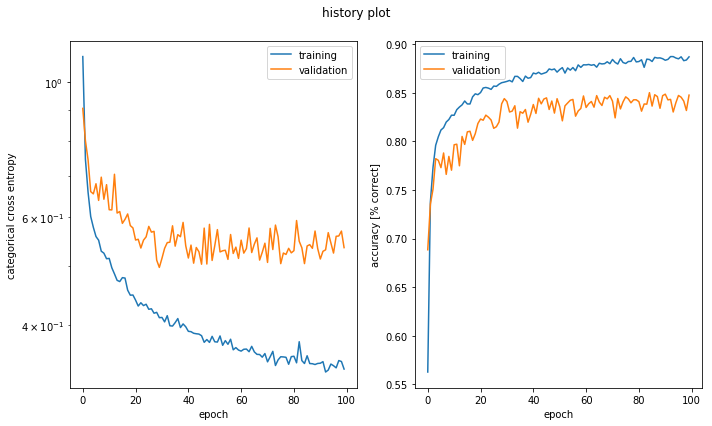

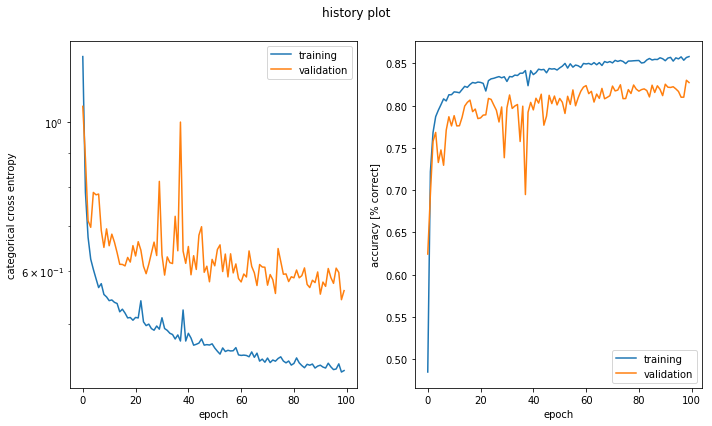

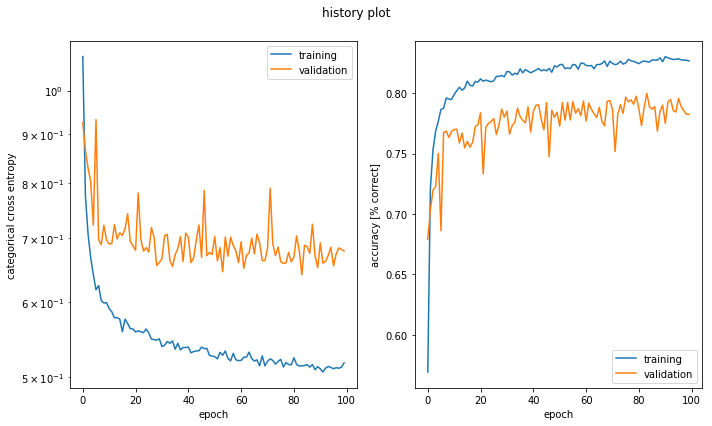

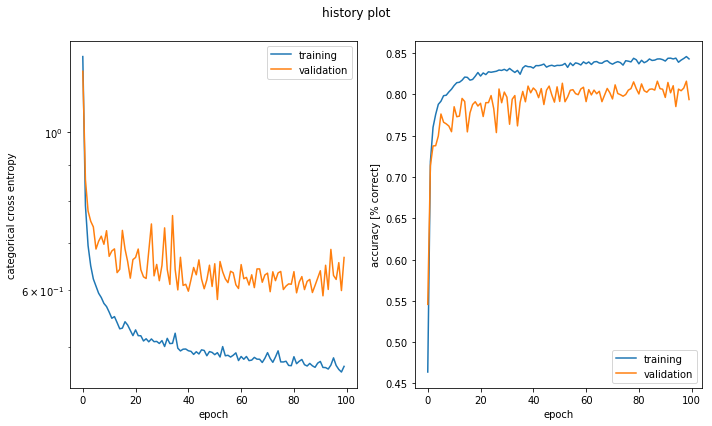

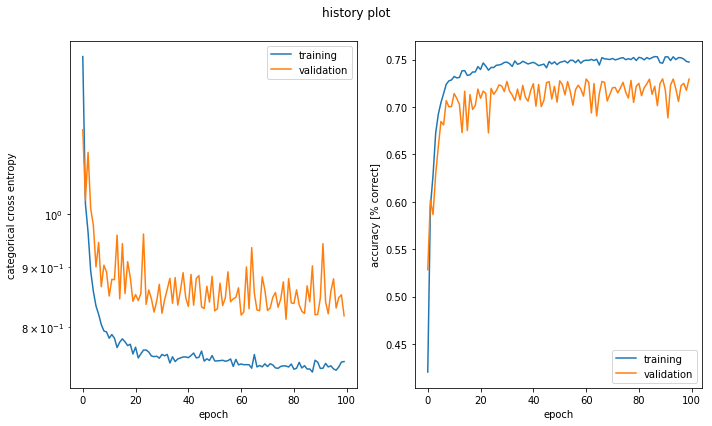

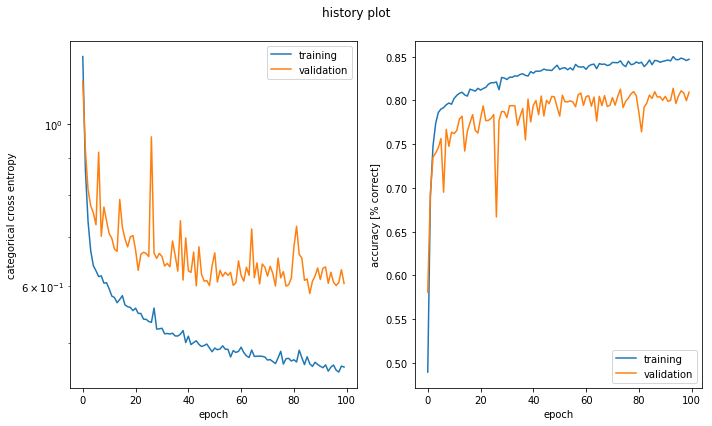

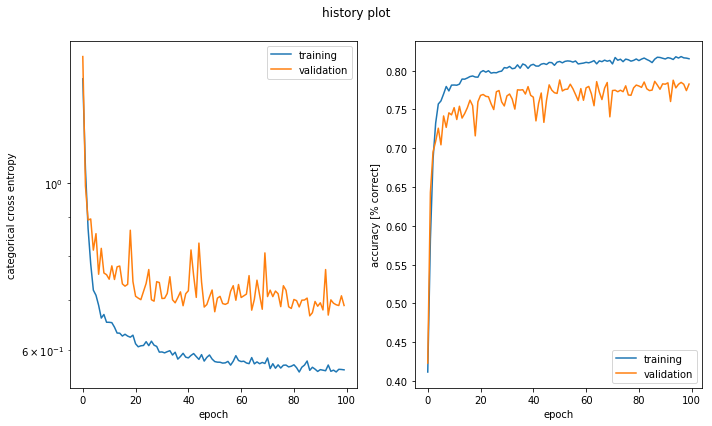

In [74]:
#K=4
model_4={'loss':[], 'acc':[]}
for i in range(N):
    print(i)
    model, history = multiple_hidden_layers(Adam(lr = 0.01), N_h=77, K=4, epochs = 100, plot=True)
    loss, acc= find_best_loss_acc(history)
    model_4["loss"].append(loss)
    model_4["acc"].append(acc)
pickle.dump(model_4, open("task5_model_4.p", "wb"))

#### Use models

In [107]:
depth = [2,3,4]

Text(0,0.5,'loss')

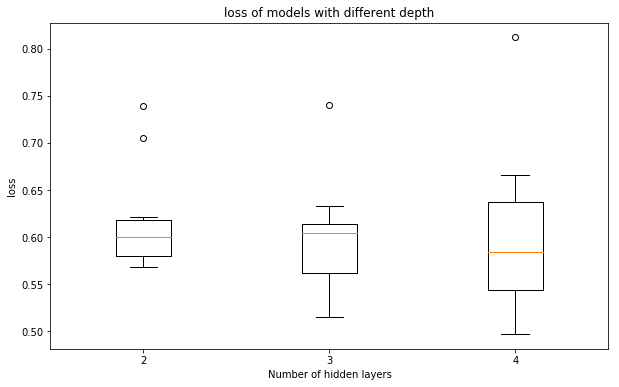

In [108]:
#TODO dodaj labels ovde i dole
res = plt.boxplot([model_2['loss'], model_3['loss'], model_4['loss']])
plt.xticks([1, 2, 3], depth) 
plt.title("loss of models with different depth")
plt.xlabel("Number of hidden layers")
plt.ylabel("loss")

Text(0,0.5,'acc')

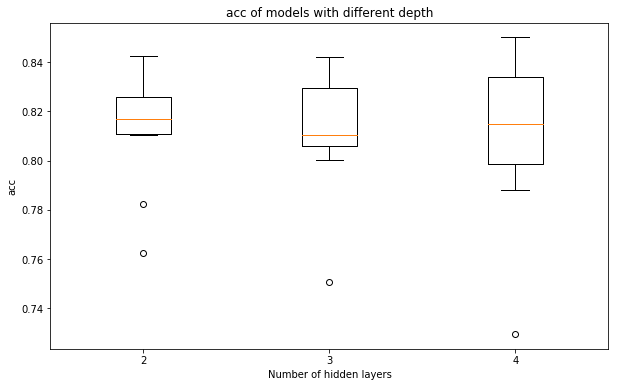

In [110]:
res = plt.boxplot([model_2['acc'], model_3['acc'], model_4['acc']])
plt.xticks([1, 2, 3], depth) 
plt.title("acc of models with different depth")
plt.xlabel("Number of hidden layers")
plt.ylabel("acc")

We observe that the three models give relatively similar results.

## Exercise 6: Tricks (regularization, batch normalization, dropout)

### Description

Overfitting can also be counteracted with regularization and dropout. Batch normalization is supposed to mainly decrease convergence time.

1. Try to improve the best validation scores of the model with 1 layer and 100 hidden neurons and the model with 4 hidden layers. Experiment with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases.
2. After you have found good settings, plot for both models the learning curves of the naive model you fitted in the previous exercises together with the learning curves of the current version.
3. For proper comparison, plot also the learning curves of the two current models in a third figure.

### Solution

#### Util functions

In [162]:
models = []
metrics={'loss':[], 'acc':[]}

def hyperparameter_optimization(N_h=100, K=1, epochs=10):

    param_reg= [0.001, 0.01, 0.1]
    param_dropout=[0, 0.2, 0.5] 
    regulizers = [None, l2, l1]
    batch_norm = [False, True]

    #hyperparameter search
    max_acc = 0
    flag = 0

    for drop in param_dropout:
        for reg_type in regulizers:
            for batch in batch_norm:
                for reg in param_reg:
                    if reg_type!=None or reg_type==None and flag==0:
                        print('Regulizer: {} with param {}, Dropout: {}, Batch normalization: {}'.format(reg_type, reg, drop, batch))
                        models.append({'regulizer': reg_type, 'reg_param': reg, 'dropout': drop, 'batch_normal': batch})
                        if reg_type:
                            model, history = multiple_hidden_layers(Adam(lr=0.01),  w_reg= reg_type(reg), b_reg = reg_type(reg),\
                                               dropout=drop, batch_norm = batch, N_h=N_h, K =K, epochs=epochs, plot=False, call=callbacks, verb=1)
                        else: 
                            model, history = multiple_hidden_layers(Adam(lr=0.01), w_reg= reg_type, b_reg = reg_type,\
                                               dropout=drop, batch_norm = batch, N_h=N_h, K =K, epochs=epochs, plot=False, call=callbacks, verb=1)
                            flag = 1
                        loss, acc= find_best_loss_acc(history)
                        metrics["loss"].append(loss)
                        metrics["acc"].append(acc)
                        if acc>max_acc: 
                            max_model = model
                            max_history = history
                            max_acc= acc
                            print(max_acc, "HERE")
    return max_model, max_history

#### Train models

In [78]:
#model with one layer and 100 hidden neurons
model_optim_acc_one, history_acc_one = hyperparameter_optimization(N_h=100, K=1, epochs=400)
pickle.dump(history_acc_one.history, open("history_acc_one.p", "wb"))
model_optim_acc_one.save('model_optim_acc_one.h5')
print("Best acc: \n{}".format(models[np.argmax(metrics['acc'])]))

Regulizer: None with param 0.001, Dropout: 0, Batch normalization: True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_133 (Dense)            (None, 100)               25700     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_134 (Dense)            (None, 5)                 505       
Total params: 26,605
Trainable params: 26,405
Non-trainable params: 200
_________________________________________________________________
0.846929422578
Regulizer: None with param 0.001, Dropout: 0, Batch normalization: False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_135 (Dense)            (None, 100)               25700     
__________________________________________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_155 (Dense)            (None, 100)               25700     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_156 (Dense)            (None, 5)                 505       
Total params: 26,205
Trainable params: 26,205
Non-trainable params: 0
_________________________________________________________________
Regulizer: None with param 0.001, Dropout: 0.5, Batch normalization: True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_157 (Dense)            (None, 100)               25700     
_________________________________________________________________
batch_normalization_7 (Batch (None, 100)               400      

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_175 (Dense)            (None, 100)               25700     
_________________________________________________________________
dense_176 (Dense)            (None, 5)                 505       
Total params: 26,205
Trainable params: 26,205
Non-trainable params: 0
_________________________________________________________________
Regulizer: <function l1 at 0x7fd5089c92f0> with param 0.01, Dropout: 0, Batch normalization: True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_177 (Dense)            (None, 100)               25700     
_________________________________________________________________
batch_normalization_12 (Batc (None, 100)               400       
_________________________________________________________________
dense_178 (Dense)            (None, 5)  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_195 (Dense)            (None, 100)               25700     
_________________________________________________________________
dropout_20 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_196 (Dense)            (None, 5)                 505       
Total params: 26,205
Trainable params: 26,205
Non-trainable params: 0
_________________________________________________________________
Regulizer: <function l2 at 0x7fd5089c96a8> with param 0.01, Dropout: 0.5, Batch normalization: True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_197 (Dense)            (None, 100)               25700     
_________________________________________________________________
batch_normalization_17 (Batc (None, 10

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_215 (Dense)            (None, 100)               25700     
_________________________________________________________________
dense_216 (Dense)            (None, 5)                 505       
Total params: 26,205
Trainable params: 26,205
Non-trainable params: 0
_________________________________________________________________
Regulizer: None with param 0.1, Dropout: 0.2, Batch normalization: True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_217 (Dense)            (None, 100)               25700     
_________________________________________________________________
batch_normalization_22 (Batc (None, 100)               400       
_________________________________________________________________
dropout_25 (Dropout)         (None, 100)               0         


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_235 (Dense)            (None, 100)               25700     
_________________________________________________________________
dropout_34 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_236 (Dense)            (None, 5)                 505       
Total params: 26,205
Trainable params: 26,205
Non-trainable params: 0
_________________________________________________________________
Regulizer: <function l1 at 0x7fd5089c92f0> with param 0.1, Dropout: 0.5, Batch normalization: True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_237 (Dense)            (None, 100)               25700     
_________________________________________________________________
batch_normalization_27 (Batc (None, 100

In [79]:
model_naive_one, history_naive_one = multiple_hidden_layers(Adam(lr=0.01),  w_reg= None, b_reg = None,\
                                        dropout=None, batch_norm = False, N_h=100, K =1, epochs=400, plot=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_241 (Dense)            (None, 100)               25700     
_________________________________________________________________
dense_242 (Dense)            (None, 5)                 505       
Total params: 26,205
Trainable params: 26,205
Non-trainable params: 0
_________________________________________________________________


In [163]:
#model with 4 layers
model_optim_acc_four, history_acc_four = hyperparameter_optimization(N_h=59, K=4, epochs=20)
pickle.dump(history_acc_four.history, open("history_acc_four.p", "wb"))
model_optim_acc_four.save('model_optim_acc_four.h5')
print("Best acc: \n{}".format(models[np.argmax(metrics['acc'])]))

Regulizer: None with param 0.001, Dropout: 0, Batch normalization: False
Train on 40456 samples, validate on 14183 samples
Epoch 1/20
40456/40456 [==============================] - 39s 974us/step - loss: 1.1374 - acc: 0.5346 - val_loss: 1.0208 - val_acc: 0.6313
Epoch 2/20
40456/40456 [==============================] - 5s 123us/step - loss: 0.7487 - acc: 0.7343 - val_loss: 0.7758 - val_acc: 0.7285
Epoch 3/20
40456/40456 [==============================] - 5s 128us/step - loss: 0.6698 - acc: 0.7668 - val_loss: 0.8232 - val_acc: 0.7298
Epoch 4/20
40456/40456 [==============================] - 5s 128us/step - loss: 0.6354 - acc: 0.7815 - val_loss: 0.7494 - val_acc: 0.7465
Epoch 5/20
40456/40456 [==============================] - 5s 128us/step - loss: 0.6050 - acc: 0.7932 - val_loss: 0.6964 - val_acc: 0.7706
Epoch 6/20
40456/40456 [==============================] - 5s 131us/step - loss: 0.5766 - acc: 0.8052 - val_loss: 0.6482 - val_acc: 0.7902
Epoch 7/20
40456/40456 [========================

40456/40456 [==============================] - 5s 125us/step - loss: 1.5460 - acc: 0.3426 - val_loss: 1.5346 - val_acc: 0.3595
Epoch 3/20
40456/40456 [==============================] - 5s 124us/step - loss: 1.5459 - acc: 0.3426 - val_loss: 1.5347 - val_acc: 0.3595
Epoch 4/20
40456/40456 [==============================] - 5s 125us/step - loss: 1.5460 - acc: 0.3426 - val_loss: 1.5343 - val_acc: 0.3595
Epoch 5/20
40456/40456 [==============================] - 6s 149us/step - loss: 1.5459 - acc: 0.3426 - val_loss: 1.5354 - val_acc: 0.3595
Epoch 6/20
40456/40456 [==============================] - 5s 126us/step - loss: 1.5461 - acc: 0.3426 - val_loss: 1.5351 - val_acc: 0.3595
Epoch 7/20
40456/40456 [==============================] - 5s 115us/step - loss: 1.5461 - acc: 0.3426 - val_loss: 1.5348 - val_acc: 0.3595
Epoch 8/20
40456/40456 [==============================] - 4s 104us/step - loss: 1.5461 - acc: 0.3426 - val_loss: 1.5354 - val_acc: 0.3595
Epoch 9/20
40456/40456 [=====================

40456/40456 [==============================] - 5s 125us/step - loss: 1.5732 - acc: 0.3426 - val_loss: 1.5623 - val_acc: 0.3595
Epoch 5/20
40456/40456 [==============================] - 5s 125us/step - loss: 1.5733 - acc: 0.3426 - val_loss: 1.5631 - val_acc: 0.3595
Epoch 6/20
40456/40456 [==============================] - 5s 125us/step - loss: 1.5733 - acc: 0.3426 - val_loss: 1.5614 - val_acc: 0.3595
Epoch 7/20
40456/40456 [==============================] - 5s 125us/step - loss: 1.5736 - acc: 0.3426 - val_loss: 1.5616 - val_acc: 0.3595
Epoch 8/20
40456/40456 [==============================] - 5s 125us/step - loss: 1.5736 - acc: 0.3426 - val_loss: 1.5619 - val_acc: 0.3595
Epoch 9/20
40456/40456 [==============================] - 5s 125us/step - loss: 1.5732 - acc: 0.3426 - val_loss: 1.5619 - val_acc: 0.3595
Epoch 10/20
40456/40456 [==============================] - 5s 126us/step - loss: 1.5734 - acc: 0.3426 - val_loss: 1.5614 - val_acc: 0.3595
Epoch 11/20
40456/40456 [===================

Epoch 7/20
40456/40456 [==============================] - 4s 104us/step - loss: 4.9287 - acc: 0.3426 - val_loss: 4.9932 - val_acc: 0.3595
Epoch 8/20
40456/40456 [==============================] - 4s 103us/step - loss: 4.9322 - acc: 0.3426 - val_loss: 4.8897 - val_acc: 0.3595
Epoch 9/20
40456/40456 [==============================] - 5s 130us/step - loss: 4.9291 - acc: 0.3426 - val_loss: 4.8441 - val_acc: 0.3595
Epoch 10/20
40456/40456 [==============================] - 6s 146us/step - loss: 4.9299 - acc: 0.3426 - val_loss: 4.8506 - val_acc: 0.3595
Epoch 11/20
40456/40456 [==============================] - 5s 129us/step - loss: 4.9293 - acc: 0.3426 - val_loss: 4.9094 - val_acc: 0.3595
Epoch 12/20
40456/40456 [==============================] - 5s 126us/step - loss: 4.9285 - acc: 0.3426 - val_loss: 4.9191 - val_acc: 0.3595
Epoch 13/20
40456/40456 [==============================] - 5s 127us/step - loss: 4.9305 - acc: 0.3426 - val_loss: 4.9573 - val_acc: 0.3595
Epoch 14/20
40456/40456 [=====

Epoch 6/20
40456/40456 [==============================] - 5s 120us/step - loss: 1.5460 - acc: 0.3426 - val_loss: 1.5343 - val_acc: 0.3595
Epoch 7/20
40456/40456 [==============================] - 6s 150us/step - loss: 1.5460 - acc: 0.3426 - val_loss: 1.5353 - val_acc: 0.3595
Epoch 8/20
40456/40456 [==============================] - 6s 158us/step - loss: 1.5462 - acc: 0.3426 - val_loss: 1.5366 - val_acc: 0.3595
Epoch 9/20
40456/40456 [==============================] - 6s 140us/step - loss: 1.5460 - acc: 0.3426 - val_loss: 1.5354 - val_acc: 0.3595
Epoch 10/20
40456/40456 [==============================] - 5s 123us/step - loss: 1.5458 - acc: 0.3426 - val_loss: 1.5354 - val_acc: 0.3595
Epoch 11/20
40456/40456 [==============================] - 5s 113us/step - loss: 1.5464 - acc: 0.3426 - val_loss: 1.5354 - val_acc: 0.3595
Epoch 12/20
40456/40456 [==============================] - 5s 126us/step - loss: 1.5462 - acc: 0.3426 - val_loss: 1.5365 - val_acc: 0.3595
Epoch 13/20
40456/40456 [======

40456/40456 [==============================] - 35s 856us/step - loss: 1.6452 - acc: 0.3420 - val_loss: 1.5628 - val_acc: 0.3595
Epoch 2/20
40456/40456 [==============================] - 7s 168us/step - loss: 1.5734 - acc: 0.3426 - val_loss: 1.5617 - val_acc: 0.3595
Epoch 3/20
40456/40456 [==============================] - 7s 169us/step - loss: 1.5733 - acc: 0.3426 - val_loss: 1.5614 - val_acc: 0.3595
Epoch 4/20
40456/40456 [==============================] - 6s 144us/step - loss: 1.5733 - acc: 0.3426 - val_loss: 1.5618 - val_acc: 0.3595
Epoch 5/20
40456/40456 [==============================] - 6s 144us/step - loss: 1.5734 - acc: 0.3426 - val_loss: 1.5611 - val_acc: 0.3595
Epoch 6/20
40456/40456 [==============================] - 6s 146us/step - loss: 1.5735 - acc: 0.3426 - val_loss: 1.5617 - val_acc: 0.3595
Epoch 7/20
40456/40456 [==============================] - 5s 135us/step - loss: 1.5735 - acc: 0.3426 - val_loss: 1.5617 - val_acc: 0.3595
Epoch 8/20
40456/40456 [====================

Train on 40456 samples, validate on 14183 samples
Epoch 1/20
40456/40456 [==============================] - 28s 690us/step - loss: 10.0069 - acc: 0.3409 - val_loss: 4.9407 - val_acc: 0.3595
Epoch 2/20
40456/40456 [==============================] - 6s 150us/step - loss: 4.9261 - acc: 0.3426 - val_loss: 5.0052 - val_acc: 0.3595
Epoch 3/20
40456/40456 [==============================] - 8s 195us/step - loss: 4.9247 - acc: 0.3426 - val_loss: 4.9187 - val_acc: 0.3595
Epoch 4/20
40456/40456 [==============================] - 7s 174us/step - loss: 4.9226 - acc: 0.3426 - val_loss: 4.8935 - val_acc: 0.3595
Epoch 5/20
40456/40456 [==============================] - 7s 179us/step - loss: 4.9220 - acc: 0.3426 - val_loss: 4.8333 - val_acc: 0.3595
Epoch 6/20
40456/40456 [==============================] - 6s 138us/step - loss: 4.9212 - acc: 0.3426 - val_loss: 4.9350 - val_acc: 0.3595
Epoch 7/20
40456/40456 [==============================] - 5s 136us/step - loss: 4.9203 - acc: 0.3426 - val_loss: 4.9469 

Train on 40456 samples, validate on 14183 samples
Epoch 1/20
40456/40456 [==============================] - 26s 646us/step - loss: 1.6124 - acc: 0.3418 - val_loss: 1.5351 - val_acc: 0.3595
Epoch 2/20
40456/40456 [==============================] - 5s 135us/step - loss: 1.5458 - acc: 0.3426 - val_loss: 1.5347 - val_acc: 0.3595
Epoch 3/20
40456/40456 [==============================] - 6s 142us/step - loss: 1.5461 - acc: 0.3426 - val_loss: 1.5353 - val_acc: 0.3595
Epoch 4/20
40456/40456 [==============================] - 6s 138us/step - loss: 1.5461 - acc: 0.3426 - val_loss: 1.5354 - val_acc: 0.3595
Epoch 5/20
40456/40456 [==============================] - 8s 203us/step - loss: 1.5461 - acc: 0.3426 - val_loss: 1.5349 - val_acc: 0.3595
Epoch 6/20
40456/40456 [==============================] - 6s 148us/step - loss: 1.5461 - acc: 0.3426 - val_loss: 1.5345 - val_acc: 0.3595
Epoch 7/20
40456/40456 [==============================] - 5s 120us/step - loss: 1.5462 - acc: 0.3426 - val_loss: 1.5356 -

Train on 40456 samples, validate on 14183 samples
Epoch 1/20
40456/40456 [==============================] - 27s 672us/step - loss: 1.7132 - acc: 0.3404 - val_loss: 1.5565 - val_acc: 0.3595
Epoch 2/20
40456/40456 [==============================] - 6s 146us/step - loss: 1.5687 - acc: 0.3426 - val_loss: 1.5579 - val_acc: 0.3595
Epoch 3/20
40456/40456 [==============================] - 5s 135us/step - loss: 1.5699 - acc: 0.3426 - val_loss: 1.5596 - val_acc: 0.3595
Epoch 4/20
40456/40456 [==============================] - 6s 137us/step - loss: 1.5706 - acc: 0.3426 - val_loss: 1.5590 - val_acc: 0.3595
Epoch 5/20
40456/40456 [==============================] - 5s 132us/step - loss: 1.5710 - acc: 0.3426 - val_loss: 1.5597 - val_acc: 0.3595
Epoch 6/20
40456/40456 [==============================] - 6s 139us/step - loss: 1.5713 - acc: 0.3426 - val_loss: 1.5600 - val_acc: 0.3595
Epoch 7/20
40456/40456 [==============================] - 6s 145us/step - loss: 1.5715 - acc: 0.3426 - val_loss: 1.5601 -

Train on 40456 samples, validate on 14183 samples
Epoch 1/20
40456/40456 [==============================] - 27s 667us/step - loss: 9.9609 - acc: 0.3403 - val_loss: 4.8989 - val_acc: 0.3595
Epoch 2/20
40456/40456 [==============================] - 6s 145us/step - loss: 4.9105 - acc: 0.3426 - val_loss: 4.9608 - val_acc: 0.3595
Epoch 3/20
40456/40456 [==============================] - 5s 135us/step - loss: 4.9091 - acc: 0.3426 - val_loss: 4.9283 - val_acc: 0.3595
Epoch 4/20
40456/40456 [==============================] - 5s 135us/step - loss: 4.9088 - acc: 0.3426 - val_loss: 4.9066 - val_acc: 0.3595
Epoch 5/20
40456/40456 [==============================] - 5s 134us/step - loss: 4.9088 - acc: 0.3426 - val_loss: 4.8410 - val_acc: 0.3595
Epoch 6/20
40456/40456 [==============================] - 5s 135us/step - loss: 4.9078 - acc: 0.3426 - val_loss: 4.9194 - val_acc: 0.3595
Epoch 7/20
40456/40456 [==============================] - 5s 136us/step - loss: 4.9073 - acc: 0.3426 - val_loss: 4.9438 -

In [168]:
model_naive_four, history_naive_four = multiple_hidden_layers(Adam(lr=0.01), w_reg= None, b_reg = None,\
                                      dropout=None, batch_norm = False, N_h=59, K =4, epochs=400, plot=False, verb=1)

Train on 40456 samples, validate on 14183 samples
Epoch 1/400
40456/40456 [==============================] - 44s 1ms/step - loss: 1.2199 - acc: 0.4930 - val_loss: 1.0402 - val_acc: 0.6110
Epoch 2/400
40456/40456 [==============================] - 5s 114us/step - loss: 0.7595 - acc: 0.7278 - val_loss: 0.8157 - val_acc: 0.7149
Epoch 3/400
40456/40456 [==============================] - 5s 112us/step - loss: 0.6865 - acc: 0.7613 - val_loss: 0.8917 - val_acc: 0.6860
Epoch 4/400
40456/40456 [==============================] - 4s 110us/step - loss: 0.6421 - acc: 0.7793 - val_loss: 0.7560 - val_acc: 0.7461
Epoch 5/400
40456/40456 [==============================] - 5s 125us/step - loss: 0.6198 - acc: 0.7869 - val_loss: 0.6733 - val_acc: 0.7740
Epoch 6/400
40456/40456 [==============================] - 5s 131us/step - loss: 0.5878 - acc: 0.8000 - val_loss: 0.8281 - val_acc: 0.7233
Epoch 7/400
40456/40456 [==============================] - 6s 141us/step - loss: 0.5940 - acc: 0.7968 - val_loss: 0.7

40456/40456 [==============================] - 5s 126us/step - loss: 0.4277 - acc: 0.8577 - val_loss: 0.5740 - val_acc: 0.8211
Epoch 60/400
40456/40456 [==============================] - 5s 124us/step - loss: 0.4234 - acc: 0.8583 - val_loss: 0.5794 - val_acc: 0.8218
Epoch 61/400
40456/40456 [==============================] - 5s 127us/step - loss: 0.4213 - acc: 0.8584 - val_loss: 0.5756 - val_acc: 0.8225
Epoch 62/400
40456/40456 [==============================] - 5s 123us/step - loss: 0.4167 - acc: 0.8606 - val_loss: 0.5854 - val_acc: 0.8123
Epoch 63/400
40456/40456 [==============================] - 5s 120us/step - loss: 0.4272 - acc: 0.8573 - val_loss: 0.5644 - val_acc: 0.8204
Epoch 64/400
40456/40456 [==============================] - 5s 118us/step - loss: 0.4150 - acc: 0.8613 - val_loss: 0.5639 - val_acc: 0.8236
Epoch 65/400
40456/40456 [==============================] - 5s 120us/step - loss: 0.4174 - acc: 0.8607 - val_loss: 0.5341 - val_acc: 0.8304
Epoch 66/400
40456/40456 [=======

40456/40456 [==============================] - 5s 126us/step - loss: 0.3860 - acc: 0.8716 - val_loss: 0.5594 - val_acc: 0.8375
Epoch 118/400
40456/40456 [==============================] - 5s 126us/step - loss: 0.3868 - acc: 0.8702 - val_loss: 0.6050 - val_acc: 0.8134
Epoch 119/400
40456/40456 [==============================] - 5s 126us/step - loss: 0.4125 - acc: 0.8611 - val_loss: 0.5534 - val_acc: 0.8305
Epoch 120/400
40456/40456 [==============================] - 5s 123us/step - loss: 0.3908 - acc: 0.8697 - val_loss: 0.5590 - val_acc: 0.8364
Epoch 121/400
40456/40456 [==============================] - 4s 110us/step - loss: 0.3862 - acc: 0.8715 - val_loss: 0.5137 - val_acc: 0.8416
Epoch 122/400
40456/40456 [==============================] - 4s 111us/step - loss: 0.3847 - acc: 0.8714 - val_loss: 0.5536 - val_acc: 0.8296
Epoch 123/400
40456/40456 [==============================] - 4s 110us/step - loss: 0.3855 - acc: 0.8702 - val_loss: 0.5550 - val_acc: 0.8352
Epoch 124/400
40456/40456 [

40456/40456 [==============================] - 4s 111us/step - loss: 0.3767 - acc: 0.8744 - val_loss: 0.5284 - val_acc: 0.8367
Epoch 176/400
40456/40456 [==============================] - 4s 111us/step - loss: 0.3631 - acc: 0.8791 - val_loss: 0.5937 - val_acc: 0.8246
Epoch 177/400
40456/40456 [==============================] - 4s 109us/step - loss: 0.3735 - acc: 0.8757 - val_loss: 0.4999 - val_acc: 0.8502
Epoch 178/400
40456/40456 [==============================] - 4s 110us/step - loss: 0.3678 - acc: 0.8770 - val_loss: 0.5249 - val_acc: 0.8463
Epoch 179/400
40456/40456 [==============================] - 5s 111us/step - loss: 0.3619 - acc: 0.8790 - val_loss: 0.5378 - val_acc: 0.8491
Epoch 180/400
40456/40456 [==============================] - 4s 111us/step - loss: 0.3639 - acc: 0.8772 - val_loss: 0.5322 - val_acc: 0.8430
Epoch 181/400
40456/40456 [==============================] - 4s 110us/step - loss: 0.3719 - acc: 0.8759 - val_loss: 0.5482 - val_acc: 0.8395
Epoch 182/400
40456/40456 [

40456/40456 [==============================] - 5s 112us/step - loss: 0.3670 - acc: 0.8773 - val_loss: 0.5621 - val_acc: 0.8330
Epoch 234/400
40456/40456 [==============================] - 5s 113us/step - loss: 0.3629 - acc: 0.8798 - val_loss: 0.5447 - val_acc: 0.8417
Epoch 235/400
40456/40456 [==============================] - 5s 115us/step - loss: 0.3552 - acc: 0.8826 - val_loss: 0.5631 - val_acc: 0.8348
Epoch 236/400
40456/40456 [==============================] - 4s 111us/step - loss: 0.3540 - acc: 0.8807 - val_loss: 0.5435 - val_acc: 0.8392
Epoch 237/400
40456/40456 [==============================] - 5s 118us/step - loss: 0.3591 - acc: 0.8803 - val_loss: 0.5510 - val_acc: 0.8390
Epoch 238/400
40456/40456 [==============================] - 5s 112us/step - loss: 0.3647 - acc: 0.8775 - val_loss: 0.5451 - val_acc: 0.8366
Epoch 239/400
40456/40456 [==============================] - 4s 110us/step - loss: 0.3661 - acc: 0.8783 - val_loss: 0.5528 - val_acc: 0.8413
Epoch 240/400
40456/40456 [

40456/40456 [==============================] - 5s 128us/step - loss: 0.3597 - acc: 0.8812 - val_loss: 0.5459 - val_acc: 0.8380
Epoch 292/400
40456/40456 [==============================] - 5s 131us/step - loss: 0.3503 - acc: 0.8833 - val_loss: 0.5841 - val_acc: 0.8246
Epoch 293/400
40456/40456 [==============================] - 5s 128us/step - loss: 0.3637 - acc: 0.8810 - val_loss: 0.5505 - val_acc: 0.8431
Epoch 294/400
40456/40456 [==============================] - 5s 126us/step - loss: 0.3503 - acc: 0.8837 - val_loss: 0.5779 - val_acc: 0.8427
Epoch 295/400
40456/40456 [==============================] - 5s 128us/step - loss: 0.3437 - acc: 0.8853 - val_loss: 0.5722 - val_acc: 0.8387
Epoch 296/400
40456/40456 [==============================] - 5s 131us/step - loss: 0.3467 - acc: 0.8858 - val_loss: 0.5702 - val_acc: 0.8373
Epoch 297/400
40456/40456 [==============================] - 5s 127us/step - loss: 0.3493 - acc: 0.8838 - val_loss: 0.5673 - val_acc: 0.8416
Epoch 298/400
40456/40456 [

40456/40456 [==============================] - 5s 126us/step - loss: 0.3435 - acc: 0.8875 - val_loss: 0.5415 - val_acc: 0.8428
Epoch 350/400
40456/40456 [==============================] - 5s 125us/step - loss: 0.3386 - acc: 0.8885 - val_loss: 0.7139 - val_acc: 0.8062
Epoch 351/400
40456/40456 [==============================] - 5s 131us/step - loss: 0.3802 - acc: 0.8753 - val_loss: 0.5757 - val_acc: 0.8297
Epoch 352/400
 1792/40456 [>.............................] - ETA: 8s - loss: 0.4423 - acc: 0.8610 

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189036). Check your callbacks.
  % delta_t_median)


40456/40456 [==============================] - 6s 138us/step - loss: 0.3456 - acc: 0.8862 - val_loss: 0.5379 - val_acc: 0.8448
Epoch 353/400
40456/40456 [==============================] - 5s 129us/step - loss: 0.3341 - acc: 0.8902 - val_loss: 0.5573 - val_acc: 0.8373
Epoch 354/400
40456/40456 [==============================] - 5s 128us/step - loss: 0.3398 - acc: 0.8879 - val_loss: 0.5453 - val_acc: 0.8447
Epoch 355/400
40456/40456 [==============================] - 5s 128us/step - loss: 0.3512 - acc: 0.8838 - val_loss: 0.5611 - val_acc: 0.8358
Epoch 356/400
40456/40456 [==============================] - 5s 132us/step - loss: 0.3379 - acc: 0.8880 - val_loss: 0.5450 - val_acc: 0.8421
Epoch 357/400
40456/40456 [==============================] - 5s 125us/step - loss: 0.3373 - acc: 0.8886 - val_loss: 0.5420 - val_acc: 0.8398
Epoch 358/400
40456/40456 [==============================] - 5s 126us/step - loss: 0.3428 - acc: 0.8869 - val_loss: 0.5682 - val_acc: 0.8433
Epoch 359/400
40456/40456 [

In [169]:
model_optim_acc_four, history_acc_four = multiple_hidden_layers(Adam(lr=0.01), w_reg= None, b_reg = None,\
                                       dropout=0, batch_norm = True, N_h=59, K =4, epochs=400, plot=False, verb=1)

Train on 40456 samples, validate on 14183 samples
Epoch 1/400
40456/40456 [==============================] - 76s 2ms/step - loss: 0.8638 - acc: 0.6809 - val_loss: 0.9576 - val_acc: 0.6991
Epoch 2/400
40456/40456 [==============================] - 7s 181us/step - loss: 0.6434 - acc: 0.7776 - val_loss: 1.6121 - val_acc: 0.5059
Epoch 3/400
40456/40456 [==============================] - 7s 164us/step - loss: 0.5974 - acc: 0.7949 - val_loss: 1.0186 - val_acc: 0.6352
Epoch 4/400
40456/40456 [==============================] - 7s 166us/step - loss: 0.5831 - acc: 0.7991 - val_loss: 0.7314 - val_acc: 0.7653
Epoch 5/400
40456/40456 [==============================] - 7s 167us/step - loss: 0.5526 - acc: 0.8102 - val_loss: 1.2328 - val_acc: 0.5947
Epoch 6/400
40456/40456 [==============================] - 7s 172us/step - loss: 0.5259 - acc: 0.8196 - val_loss: 0.7775 - val_acc: 0.7405
Epoch 7/400
40456/40456 [==============================] - 7s 169us/step - loss: 0.5028 - acc: 0.8274 - val_loss: 0.6

40456/40456 [==============================] - 6s 140us/step - loss: 0.3150 - acc: 0.8934 - val_loss: 0.5023 - val_acc: 0.8395
Epoch 60/400
40456/40456 [==============================] - 6s 155us/step - loss: 0.2925 - acc: 0.8998 - val_loss: 0.4357 - val_acc: 0.8640
Epoch 61/400
40456/40456 [==============================] - 7s 173us/step - loss: 0.2782 - acc: 0.9041 - val_loss: 0.4504 - val_acc: 0.8585
Epoch 62/400
40456/40456 [==============================] - 7s 174us/step - loss: 0.2837 - acc: 0.9032 - val_loss: 0.4647 - val_acc: 0.8546
Epoch 63/400
40456/40456 [==============================] - 7s 168us/step - loss: 0.2813 - acc: 0.9046 - val_loss: 0.5063 - val_acc: 0.8378
Epoch 64/400
40456/40456 [==============================] - 7s 171us/step - loss: 0.2875 - acc: 0.9001 - val_loss: 0.4692 - val_acc: 0.8531
Epoch 65/400
40456/40456 [==============================] - 7s 175us/step - loss: 0.2816 - acc: 0.9035 - val_loss: 0.6540 - val_acc: 0.7970
Epoch 66/400
40456/40456 [=======

40456/40456 [==============================] - 6s 154us/step - loss: 0.2798 - acc: 0.9031 - val_loss: 0.4910 - val_acc: 0.8492
Epoch 118/400
40456/40456 [==============================] - 6s 156us/step - loss: 0.2549 - acc: 0.9112 - val_loss: 0.4678 - val_acc: 0.8553
Epoch 119/400
40456/40456 [==============================] - 6s 155us/step - loss: 0.2430 - acc: 0.9162 - val_loss: 0.5270 - val_acc: 0.8414
Epoch 120/400
40456/40456 [==============================] - 6s 156us/step - loss: 0.2488 - acc: 0.9123 - val_loss: 0.4916 - val_acc: 0.8504
Epoch 121/400
40456/40456 [==============================] - 6s 149us/step - loss: 0.2404 - acc: 0.9171 - val_loss: 0.5104 - val_acc: 0.8471
Epoch 122/400
40456/40456 [==============================] - 6s 140us/step - loss: 0.2552 - acc: 0.9115 - val_loss: 0.4642 - val_acc: 0.8607
Epoch 123/400
40456/40456 [==============================] - 6s 141us/step - loss: 0.2346 - acc: 0.9191 - val_loss: 0.4935 - val_acc: 0.8556
Epoch 124/400
40456/40456 [

40456/40456 [==============================] - 7s 169us/step - loss: 0.2054 - acc: 0.9291 - val_loss: 0.4971 - val_acc: 0.8600
Epoch 176/400
40456/40456 [==============================] - 7s 174us/step - loss: 0.2185 - acc: 0.9233 - val_loss: 0.4850 - val_acc: 0.8607
Epoch 177/400
40456/40456 [==============================] - 7s 171us/step - loss: 0.2231 - acc: 0.9227 - val_loss: 0.5362 - val_acc: 0.8391
Epoch 178/400
40456/40456 [==============================] - 7s 177us/step - loss: 0.2308 - acc: 0.9188 - val_loss: 0.4862 - val_acc: 0.8600
Epoch 179/400
40456/40456 [==============================] - 7s 179us/step - loss: 0.2155 - acc: 0.9249 - val_loss: 0.4805 - val_acc: 0.8631
Epoch 180/400
40456/40456 [==============================] - 7s 178us/step - loss: 0.2192 - acc: 0.9226 - val_loss: 0.4934 - val_acc: 0.8619
Epoch 181/400
40456/40456 [==============================] - 7s 172us/step - loss: 0.2162 - acc: 0.9255 - val_loss: 0.5133 - val_acc: 0.8539
Epoch 182/400
40456/40456 [

40456/40456 [==============================] - 7s 183us/step - loss: 0.2208 - acc: 0.9225 - val_loss: 0.5044 - val_acc: 0.8574
Epoch 234/400
40456/40456 [==============================] - 7s 179us/step - loss: 0.1984 - acc: 0.9299 - val_loss: 0.5010 - val_acc: 0.8612
Epoch 235/400
40456/40456 [==============================] - 8s 196us/step - loss: 0.1970 - acc: 0.9307 - val_loss: 0.5294 - val_acc: 0.8550
Epoch 236/400
40456/40456 [==============================] - 7s 166us/step - loss: 0.2120 - acc: 0.9254 - val_loss: 0.5008 - val_acc: 0.8623
Epoch 237/400
40456/40456 [==============================] - 7s 178us/step - loss: 0.2006 - acc: 0.9295 - val_loss: 0.5209 - val_acc: 0.8598
Epoch 238/400
40456/40456 [==============================] - 7s 174us/step - loss: 0.1987 - acc: 0.9296 - val_loss: 0.5156 - val_acc: 0.8580
Epoch 239/400
40456/40456 [==============================] - 8s 196us/step - loss: 0.1980 - acc: 0.9309 - val_loss: 0.5262 - val_acc: 0.8577
Epoch 240/400
40456/40456 [

40456/40456 [==============================] - 7s 166us/step - loss: 0.1957 - acc: 0.9307 - val_loss: 0.5210 - val_acc: 0.8605
Epoch 292/400
40456/40456 [==============================] - 7s 165us/step - loss: 0.1896 - acc: 0.9314 - val_loss: 0.5231 - val_acc: 0.8554
Epoch 293/400
40456/40456 [==============================] - 7s 172us/step - loss: 0.2026 - acc: 0.9301 - val_loss: 0.5375 - val_acc: 0.8554
Epoch 294/400
40456/40456 [==============================] - 7s 169us/step - loss: 0.1970 - acc: 0.9315 - val_loss: 0.5079 - val_acc: 0.8625
Epoch 295/400
40456/40456 [==============================] - 7s 170us/step - loss: 0.2022 - acc: 0.9304 - val_loss: 0.5287 - val_acc: 0.8575
Epoch 296/400
40456/40456 [==============================] - 7s 171us/step - loss: 0.1806 - acc: 0.9352 - val_loss: 0.5434 - val_acc: 0.8593
Epoch 297/400
40456/40456 [==============================] - 7s 176us/step - loss: 0.2018 - acc: 0.9287 - val_loss: 0.5371 - val_acc: 0.8566
Epoch 298/400
40456/40456 [

40456/40456 [==============================] - 7s 178us/step - loss: 0.1832 - acc: 0.9354 - val_loss: 0.5369 - val_acc: 0.8596
Epoch 350/400
40456/40456 [==============================] - 7s 179us/step - loss: 0.1822 - acc: 0.9357 - val_loss: 0.5590 - val_acc: 0.8529
Epoch 351/400
40456/40456 [==============================] - 7s 168us/step - loss: 0.1801 - acc: 0.9367 - val_loss: 0.5435 - val_acc: 0.8582
Epoch 352/400
40456/40456 [==============================] - 7s 177us/step - loss: 0.1770 - acc: 0.9373 - val_loss: 0.5334 - val_acc: 0.8573
Epoch 353/400
40456/40456 [==============================] - 7s 170us/step - loss: 0.1878 - acc: 0.9354 - val_loss: 0.5345 - val_acc: 0.8601
Epoch 354/400
40456/40456 [==============================] - 7s 174us/step - loss: 0.1740 - acc: 0.9380 - val_loss: 0.5338 - val_acc: 0.8599
Epoch 355/400
40456/40456 [==============================] - 8s 196us/step - loss: 0.1974 - acc: 0.9310 - val_loss: 0.5406 - val_acc: 0.8519
Epoch 356/400
40456/40456 [

#### Use models

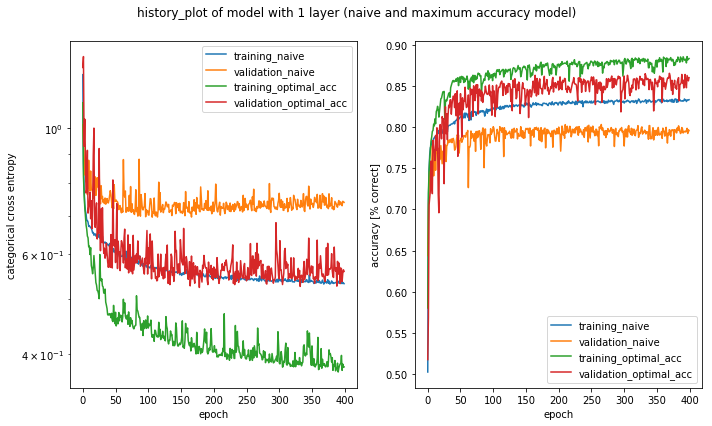

In [111]:
model which gives optimal acc
res = plot_history_two(history_naive_one, history_acc_one, 'history_plot of model with 1 layer (naive and maximum accuracy model)', labels=['naive', 'optimal_acc'])

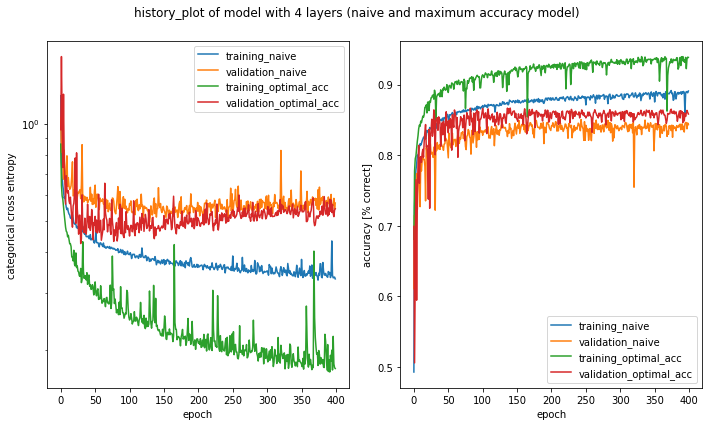

In [170]:
#model which gives optimal acc
res = plot_history_two(history_naive_four, history_acc_four, 'history_plot of model with 4 layers (naive and maximum accuracy model)', labels=['naive', 'optimal_acc'])

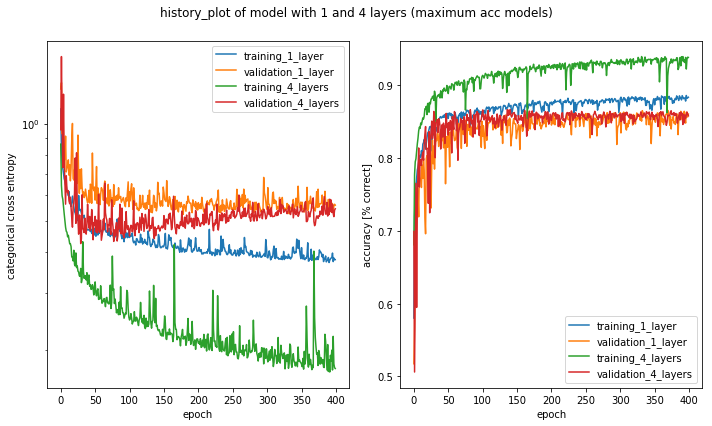

In [171]:
#compare best model with 1 layer and with 4 layers for optimal loss
res = plot_history_two(history_acc_one, history_acc_four, 'history_plot of model with 1 and 4 layers (maximum acc models)', labels=['1_layer', '4_layers'])

#### Choose best model

In [173]:
if find_best_loss_acc(history_acc_four)[1]>find_best_loss_acc(history_acc_one)[1]:
    model_acc_best = model_optim_acc_four
    history_acc_best = history_acc_four
else:
    model_acc_best = model_optim_acc_one
    history_acc_best = history_acc_one
    
pickle.dump(history_acc_best.history, open("history_best.p", "wb"))
model_acc_best.save('model_best.h5')

## Exercise 7: Convolutional networks

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with the parameters and fit it. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_cnn](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py).
2. Plot the learning curves of the convolutional neural network together with the so far best performing model.

## Solution

#### Reshape data 

In [9]:
x_train_conv = x_train.reshape(x_train.shape[0], 16, 16, 1)
x_test_conv = x_test.reshape(x_test.shape[0], 16, 16, 1)

#### Utilization functions

In [10]:
def conv_network(x_train, y_train, x_test, y_test, size_filter1 = 32, size_filter2=64, dropout1 = 0.25, dropout2 = 0.5, full_connected=128, epochs=1, call=[]):
    model = Sequential()
    model.add(Conv2D(size_filter1, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(x_train.shape[1], x_train.shape[2], 1)))
    model.add(Conv2D(size_filter1, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout1))
    model.add(Flatten())
    model.add(Dense(fc, activation='relu'))
    model.add(Dropout(dropout2))
    model.add(Dense(5, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

    history = model.fit(x_train, y_train,
              batch_size=128,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test),
                       callbacks= call)
    #score = model.evaluate(x_test, y_test, verbose=0)
    #print('Test loss:', score[0])
    #print('Test accuracy:', score[1])
    return model, history

#### Train model

In [29]:
#hyperparameter optimization
size_filter1=[32]#[16, 32] 
size_filter2 = [64]#[32, 64] 
dropout1 = [0.5]#[0, 0.25, 0.5] 
dropout2 = [0.5]#[0, 0.5, 0.75] 
full_connected = [128]#[128, 64] 
models = []
max_acc= 0
metrics = {'loss':[], 'acc':[]}
for sf1 in size_filter1:
    for sf2 in size_filter2:
        for dp1 in dropout1:
            for dp2 in dropout2:
                for fc in full_connected:
                    current_state = {
                        'size_filter1': sf1,
                        'size_filter2': sf2,
                        'dropout1': dp1,
                        'dropout2':dp2,
                        'full_connected': fc
                    }
                    print(current_state)
                    models.append(current_state)
                    model_conv, history_conv = conv_network(x_train_conv, y_train, x_test_conv, y_test, \
                                                            size_filter1=sf1, size_filter2=sf2, \
                                                  dropout1=dp1, dropout2=dp2, full_connected=fc, epochs=100, call=callbacks)     
                    loss, acc= find_best_loss_acc(history_conv)
                    metrics["loss"].append(loss)
                    metrics["acc"].append(acc)
                    if acc>max_acc:
                        max_acc=acc
                        model_optim_acc_conv = model_conv
                        history_acc_conv = history_conv
pickle.dump(history_acc_conv.history, open("history_conv.p", "wb"))
model_optim_acc_conv.save('model_conv.h5')

{'size_filter2': 64, 'full_connected': 128, 'dropout2': 0.5, 'dropout1': 0.5, 'size_filter1': 32}
Train on 40456 samples, validate on 14183 samples
Epoch 1/100
40456/40456 [==============================] - 28s 680us/step - loss: 1.0084 - acc: 0.6215 - val_loss: 0.4997 - val_acc: 0.8633
Epoch 2/100
40456/40456 [==============================] - 28s 682us/step - loss: 0.5268 - acc: 0.8311 - val_loss: 0.3642 - val_acc: 0.8900
Epoch 3/100
40456/40456 [==============================] - 28s 688us/step - loss: 0.4319 - acc: 0.8607 - val_loss: 0.3060 - val_acc: 0.9066
Epoch 4/100
40456/40456 [==============================] - 28s 690us/step - loss: 0.3879 - acc: 0.8754 - val_loss: 0.2880 - val_acc: 0.9098
Epoch 5/100
40456/40456 [==============================] - 29s 706us/step - loss: 0.3654 - acc: 0.8824 - val_loss: 0.2782 - val_acc: 0.9171
Epoch 6/100
40456/40456 [==============================] - 28s 700us/step - loss: 0.3433 - acc: 0.8901 - val_loss: 0.2677 - val_acc: 0.9160
Epoch 7/100


In [30]:
print("Best acc: \n{}".format(models[np.argmax(metrics['acc'])]))

Best acc: 
{'size_filter2': 64, 'full_connected': 128, 'dropout2': 0.5, 'dropout1': 0.5, 'size_filter1': 32}


#### Use models

In [31]:
#load models
history_acc_conv = keras.callbacks.History()
history_acc_conv.history = pickle.load(open ("history_conv.p", "rb"))
model_optim_acc_conv = load_model('model_conv.h5')

history_best_acc = keras.callbacks.History()
history_best_acc.history = pickle.load(open ("history_best.p", "rb"))

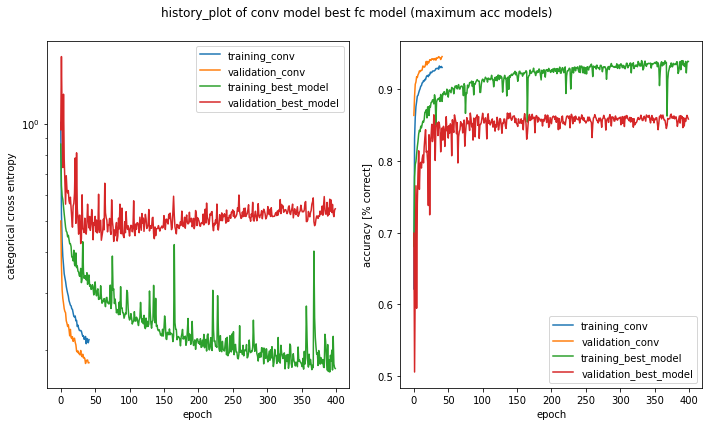

In [32]:
#compare best fc model with conv network for optimal loss
res = plot_history_two(history_acc_conv, history_best_acc, 'history_plot of conv model best fc model (maximum acc models)', labels=['conv', 'best_model'])

#### Evaluate best model

In [33]:
_, best_acc = model_optim_acc_conv.evaluate(x_test_conv, y_test, verbose=0)
print("Best accuracy is {}".format(best_acc))

Best accuracy is 0.9452161037862229


##### Finally, we conclude that convolutional network gives significantly better accuracy for this task and it should be used.